<font color='red'><b>Pour moi : trucs de code</b></font> <br>

[Ajouter une liste/un dictionnaire à un groupby : utilisation de l'astérisque](#pm1)

dummies_col = list(dummies.columns)

rfm_review_deliv_delay = data.groupby(["customer_unique_id"]).agg({\  
                                            "order_purchase_timestamp": lambda x : (date_repere-x.max()).days,  
                                            "order_id" : 'count',  
                                            "price" : "sum",  
                                            "review_score":"mean",  
                                            "delivery_delay":"mean",  
                                            **{col: "mean" for col in dummies_col}})

# SOMMAIRE

## Exploration
### Preprocessing
### Orders
### Reviews
### Payments
### Customers
### Items
### Products

## Feature Engineering
### Transformation de variables
### Création de variables

## Clustering
### Dataset 1 - RFM
### Dataset 2 - RFM + review_score + delai
### Dataset 3 - RFM + review_score + delai + category

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import joblib

# Clustering
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from scipy.cluster.hierarchy import linkage
from sklearn.preprocessing import StandardScaler

from fonctions import *
from clustering_utils import *

# Exploration

In [76]:
prefix = './archive/'

customers = pd.read_csv(prefix + 'olist_customers_dataset.csv')
geolocation = pd.read_csv(prefix + 'olist_geolocation_dataset.csv', dtype={'geolocation_zip_code_prefix': str})
items = pd.read_csv(prefix + 'olist_order_items_dataset.csv')
payments = pd.read_csv(prefix + 'olist_order_payments_dataset.csv')
reviews = pd.read_csv(prefix + 'olist_order_reviews_dataset.csv')
orders = pd.read_csv(prefix + 'olist_orders_dataset.csv').astype({'order_purchase_timestamp':'datetime64','order_approved_at':'datetime64','order_delivered_carrier_date':'datetime64','order_delivered_customer_date':'datetime64','order_estimated_delivery_date':'datetime64'})
products = pd.read_csv(prefix + 'olist_products_dataset.csv')
products_category_translation = pd.read_csv(prefix + 'product_category_name_translation.csv')
products = pd.merge(products, products_category_translation)
sellers = pd.read_csv(prefix + 'olist_sellers_dataset.csv') 

## Preprocessing

Je fusionne l'ensemble des datasets pour pouvoir sélectionner plus facilement les colonnes nécessaires.

<div>
<img src="https://i.imgur.com/HRhd2Y0.png" width="1000"/>
</div>

In [77]:
dict_csv = {'customers':customers, 'geolocation':geolocation, 'items':items, 'payments':payments,
            'reviews':reviews, 'orders':orders, 'products':products, 'sellers':sellers}

from tabulate import tabulate

to_disp = pd.DataFrame()

for name,df in dict_csv.items():
    
    statList = {'Nom':name, 'Nb lignes':[df.shape[0]],
                'Nb colonnes':[df.shape[1]],'Taille':[df.size],
                '% de NaN':[round(100.0 * (df.isna().sum().sum())/df.size,2)],
                'Nb duplicats':df.duplicated().sum(),
                "Features" : ', '.join(df.columns)}
    to_disp = pd.concat([to_disp, pd.DataFrame().from_dict(statList, orient='columns')])


print(tabulate(to_disp.reset_index(drop=True), headers = 'keys', tablefmt = 'psql'))  

+----+-------------+-------------+---------------+----------+------------+----------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | Nom         |   Nb lignes |   Nb colonnes |   Taille |   % de NaN |   Nb duplicats | Features                                                                                                                                                                                                        |
|----+-------------+-------------+---------------+----------+------------+----------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | customers   |       99441 |             5 |   497205 |       0    |              0 | cu

In [78]:
# Where are the Nans in reviews ?
reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

Observation des datasets : 
- geolocation : 5% de duplicats
- reviews : 21% de Nans
Features : 
    - customers : Id et adresse
    - geolocation : Elements d'adresse, latitude, longitude
    - items : Infos commande, numéro du vendeur, date limite de transport 
    - payments : payment_sequential ? payment_installments ?
    - reviews : Infos commentaires internet - id, score, titre, message, ...
    - orders : Dates et heures processus commande - commande par le client, approbation, expédition livraison
    - products : Nom, dimensions du produit, (mais aussi!) dimensions du nom et de la description du produit
    - sellers : Id et adresse du vendeur. Pas utile.

## Orders

Ce dataset va me permettre d'avoir des infos sur:
- Période avec le + d'achats
- Temps de livraison moyen
- Corrélation temps de livraison / reviews
- Fréquence d'achat d'un client sur une période

In [79]:
analyse_forme(orders,all=False)

+----+----------+-------------+---------------+------------+----------------+
|    |   Taille |   Nb lignes |   Nb colonnes |   % de NaN |   Nb duplicats |
|----+----------+-------------+---------------+------------+----------------|
|  0 |   795528 |       99441 |             8 |       0.62 |              0 |
+----+----------+-------------+---------------+------------+----------------+


In [80]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [81]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

### **A quelle période trouve-t-on le plus d'achats ?**

In [82]:
# filter the columns that begin with 'order'
order_cols = orders.iloc[:, 3:].columns

# convert the 'order' columns to datetime format
orders[order_cols] = orders[order_cols].apply(pd.to_datetime)

In [83]:
print(f'Première commande: {orders.order_purchase_timestamp.min()}')
print(f'Dernière commande: {orders.order_purchase_timestamp.max()}')
print(f'Période de l\'étude: {orders.order_purchase_timestamp.max() - orders.order_purchase_timestamp.min()}')

Première commande: 2016-09-04 21:15:19
Dernière commande: 2018-10-17 17:30:18
Période de l'étude: 772 days 20:14:59


<AxesSubplot:>

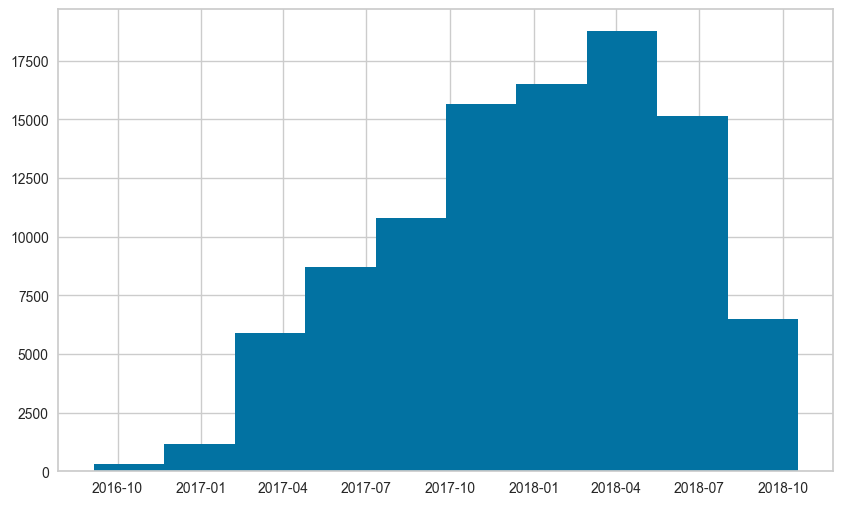

In [84]:
fig, ax = plt.subplots(figsize=(10, 6))
fig = orders.order_purchase_timestamp.hist()
fig

<font color='red'><b>Observations</b></font> <br>

- Augmentation croissante des ventes
- Diminution à partir de juin 2018
- Diminution nette à partir de aout 2018

### **Temps de livraison**

In [85]:
orders['order_delivered_delay'] = (orders.order_delivered_customer_date - orders.order_approved_at).apply(func=lambda x: x.days)

In [86]:
#import nbformat
#mesure_forme_col(orders.order_delivered_delay)

<font color='red'><b>Observations</b></font> <br>

- Présence de valeurs extremes (+ de 100 jours de délai de livraison)
- Un ou plusieurs délais de livraisons négatifs 
- 75% des temps de livraison entre 6 et 15j

## Reviews

In [87]:
reviews.head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16 00:00:00,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14 00:00:00,2018-08-14 21:36:06
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,NaN,NaN,2017-05-17 00:00:00,2017-05-18 12:05:37
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47


In [88]:
reviews.isnull().sum()/reviews.shape[0]

review_id                  0.000000
order_id                   0.000000
review_score               0.000000
review_comment_title       0.883415
review_comment_message     0.587025
review_creation_date       0.000000
review_answer_timestamp    0.000000
dtype: float64

<font color='red'><b>Observations</b></font> <br>

- Toutes les commandes ont reçu une note <br>
- 40% des commandes ont reçu un commentaire

### Répartition des review_scores

In [89]:
reviews.review_score.value_counts()

5    57328
4    19142
1    11424
3     8179
2     3151
Name: review_score, dtype: int64

<font color='red'><b>Observations</b></font> <br>

- Environ 75% des commandes se sont bien voire très bien passées (4 ou 5 *) <br>

## Payments

In [90]:
payments.sample(10)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
70162,026f3440c258a87c9f6fb9c8e1bbb6e7,1,boleto,1,47.71
22943,0764f8b9a45b0305b75e1bbd614ffaaa,1,credit_card,3,111.25
77503,b3459a0ddec3dda60a8ab19fb172dfef,1,credit_card,2,131.61
78802,b727ad9e7a5b561a3601faa56d0a1aa0,1,credit_card,1,42.77
86292,83f4ef880ab532703def37dd9c0e7348,1,boleto,1,72.14
38011,0b40648d6c533ac73822cb32caf5cfa3,1,credit_card,8,136.50
73819,522d7c3197277c13553183e4960cdf5c,1,credit_card,1,71.62
99613,74b4e28e0e0a0715ca63940014536bb7,1,credit_card,10,160.40
71330,712cb14ddeca38aaeb49dea61f811018,1,credit_card,3,63.80
90246,93430185e43190a6a3f456ac4cd38c21,1,credit_card,1,20.28


**payment_sequential** = Un client peut choisir de payer une commande avec plusieurs moyens de paiements <br>
**payment_installment** = Facilité de paiement : Paiement en plusieurs fois

### Quelles commandes ont reçu plusieurs paiements ?

In [91]:
payments.order_id.duplicated().sum()

4446

In [92]:
payments[payments.order_id.duplicated(keep=False)].sort_values(by='order_id')

,order_id,payment_sequential,payment_type,payment_installments,payment_value
80856,0016dfedd97fc2950e388d2971d718c7,2,voucher,1,17.92
89575,0016dfedd97fc2950e388d2971d718c7,1,credit_card,5,52.63
20036,002f19a65a2ddd70a090297872e6d64e,1,voucher,1,44.11
98894,002f19a65a2ddd70a090297872e6d64e,2,voucher,1,33.18
30155,0071ee2429bc1efdc43aa3e073a5290e,2,voucher,1,92.44
...,...,...,...,...,...
21648,ffa1dd97810de91a03abd7bd76d2fed1,2,voucher,1,418.73
32912,ffa39020fe7c8a3e907320e1bec4b985,1,credit_card,1,7.13
3009,ffa39020fe7c8a3e907320e1bec4b985,2,voucher,1,64.01
75188,ffc730a0615d28ec19f9cad02cb41442,1,credit_card,1,14.76


De même ici, j'ai certaines commandes qui ont reçu plusieurs paiements. <br>
Je ne comprends pas bien d'où cela vient, il s'agit peut être d'erreurs. <br>

### Quel est le type de paiement préféré ?

In [93]:
payments.payment_type.value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

<font color='red'>**Observations**</font> <br>

- Environ 75% des achats sont faits par CB <br>
- Boleto : moyen de paiement intermédiaire, sorte de carte qu'on achète avec des espèces (spécifiquement au Brésil)

### Comment sont répartis les paiements ?

In [94]:
#mesure_forme_col(payments.payment_value, bins=50, title='Répartition de la valeur des paiements', figsize=(16,12))

## Customers

In [95]:
customers.sample(10)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
65510,06212d81da710ff1cc3a5dd1afaea410,9e73f1852bb59ee9477c18dbe5f6cfb2,13401,piracicaba,SP
59499,add7aa6095dd2aae6b8d70d022bae3e5,a5bbd6eeb5346baf703a636f93182379,65066,sao luis,MA
91125,bb7eb42e14e681c6107f6a8299025323,d0d8fa36cfde7ec89c8c03a375609fb1,4002,sao paulo,SP
58157,163177629004a65178fbab8c502d2637,c421b506ac2b258ef57d2a5c216780a2,28030,campos dos goytacazes,RJ
20892,78c6ca3d7665d9763e3b7b13de57ddc5,3a977d401378248731926b9951f530de,78250,pontes e lacerda,MT
58187,b3c62a5df61ab4d3fb52abba2db12081,f58595c5ecdf5e9781678b83ba2e0c21,37940,alpinopolis,MG
44670,b9da6623473d64470e9f4bf9f600cd25,c73f294466cf13293810f4d1a3728d56,13145,paulinia,SP
83682,905c292434c3a4f6e78a5bf3468a1488,14874658d29b39139314051fc7892a11,14300,batatais,SP
81045,c86d6f7e3ec3afde83e27950cdcefce4,67517ba55bf6b8a275d7e45b15c2b317,35024,governador valadares,MG
57326,ef6ae9c605a12e4d51a8d2c6637f5603,ec9eeb5f0599d9b4c013910666b563d7,4158,sao paulo,SP


customer_id : Clé pour assembler avec le dataset *orders*, chaque commande à un customer_id unique. <br>
customer_unique_id : id unique d'un client <br>

### Plusieurs commandes par les mêmes clients

In [96]:
customers.customer_unique_id.duplicated().sum()

3345

La présence de doublons ici m'indique des clients ayant fait plusieurs commandes.

In [97]:
customers.customer_unique_id.duplicated().sum()/customers.shape[0]

0.033638036624732255

---

Je créé une nouvelle colonne contenant le nombre de commandes effectuées par ce client.

In [98]:
customers_vc = customers.customer_unique_id.value_counts()
customers['customer_total_commands'] = customers.customer_unique_id.apply(func=lambda id: customers_vc.loc[id])

In [99]:
customers.customer_total_commands.max()

17

<font color='red'><b>Observations</b></font> <br>

- 3% des clients ont fait plus d'une commande

## Items

In [100]:
items.sample(10)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
63987,92258ef4b52681cb4b474bc1ed6cd9ed,1,37dffde0476450e75dae423136954b0f,66dc1b1632bd6a3e508510c5b3492107,2018-04-03 11:50:19,149.00,18.92
93021,d2e35b4e5cffc778521aa3b668c29bcf,1,efeaa7462b9fac16b6684016efd28fd2,b2ba3715d723d245138f291a6fe42594,2017-10-13 02:35:26,209.90,20.01
4201,0978aeeb31e430bca8401306d75a8164,1,c3504adf8e5bbfd1978d29a00c2075c5,c013e57c075a06e5b5c48ee03c525719,2018-07-24 13:55:18,69.99,23.29
54151,7b138921061fdd90eace63dea3d27475,1,adb87e70152d5c87a1929b2019494320,002100f778ceb8431b7a1020ff7ab48f,2018-03-07 03:20:31,19.90,15.10
12167,1b9c491d2bd15c21c2e2cfdda8769335,5,46ca9515def9ceb56e338c86ca765ba1,18a349e75d307f4b4cc646a691ed4216,2017-10-30 02:49:21,48.00,19.59
71531,a3266d5717615919b50f2d1f62d8c0a8,1,06ef9525b604908b6ef27fa630b4f22f,d91fb3b7d041e83b64a00a3edfb37e4f,2018-07-05 11:15:14,35.60,26.55
23748,361db03164887c1d35adf146e89ac533,1,3dd2a17168ec895c781a9191c1e95ad7,de722cd6dad950a92b7d4f82673f8833,2018-03-15 04:31:41,149.90,25.18
36533,52e0844a4571e7443dd8e575e7f33480,2,488edbf15626ebb4b69d6c4600602ba3,08633c14ef2db992c11f840f04fad4cd,2018-06-12 17:53:10,15.90,19.32
55130,7d5ff38bbe8e85dd2a181ff339eb11bd,3,bdeac558883a62ab1a048c8f3a0cdf3c,1fbe10c70e30765ed1de86d9f7e98409,2018-06-28 02:59:06,6.15,7.39
93775,d48863aea86f6a6ccbcf40c4d1a38a0c,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,2018-05-09 13:30:53,99.90,0.00


TO DO : Je cherche à connaitre le prix total d'une commande ainsi que le prix total des frais de port.

## Products

In [101]:
products.sample(10)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
26603,7c8e2b381bb0fcba5b368961d7823cd2,pcs,55.0,1131.0,1.0,12050.0,27.0,50.0,53.0,computers
29247,8ab5f8c45e722c22351580a4b0fcc8ad,pet_shop,45.0,173.0,1.0,400.0,21.0,21.0,18.0,pet_shop
29568,1ff03883acc92ad1f4eb8ed40ad25bf9,agro_industria_e_comercio,43.0,1100.0,3.0,900.0,20.0,5.0,11.0,agro_industry_and_commerce
25810,f8714e3b95aadcbfb57568c5e09df884,fashion_bolsas_e_acessorios,60.0,188.0,1.0,150.0,16.0,15.0,15.0,fashion_bags_accessories
28136,1b5da3da62c9390a62e96e29cca9e734,relogios_presentes,53.0,959.0,3.0,450.0,20.0,10.0,16.0,watches_gifts
8748,2c5ae18918caa7b9adf593b80afb9b42,moveis_decoracao,46.0,548.0,4.0,500.0,30.0,30.0,11.0,furniture_decor
25076,f1d67bf6f48876883052184dbc05dcc7,papelaria,41.0,134.0,2.0,200.0,21.0,7.0,15.0,stationery
5807,2891311ed5a25e23aaaf5b12db9a8f83,utilidades_domesticas,18.0,676.0,2.0,450.0,16.0,12.0,12.0,housewares
2372,87c9f9f88ecd5b9de26a0a61e06e1d67,esporte_lazer,35.0,783.0,1.0,214.0,18.0,15.0,15.0,sports_leisure
4969,7020952e39b390bfe87c475d4c99b3d7,utilidades_domesticas,42.0,299.0,1.0,3700.0,40.0,34.0,21.0,housewares


### Répartition des catégories de produits

In [102]:
products.columns

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english'],
      dtype='object')

In [103]:
items.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [104]:
data = pd.merge(products,
                pd.merge(items,
                         pd.merge(customers,
                                  pd.merge(payments,
                                           pd.merge(orders,
                                                    reviews,
                                                    how='inner', on='order_id'
                                                   ),
                                           how='inner', on='order_id'
                                          ),
                                  how='inner', on='customer_id'
                                 ),
                         how='inner', on='order_id'
                        ),
                how='inner', on='product_id'
               )

In [105]:
joblib.dump(data, "data_")

['data_']

JOINTURE POUR L'INSTANT IMPOSSIBLE AVEC GEOLCOATION CAR ON NE SAIT PAS S'IL FAUT UTILISER LE ZIP CODE DU CONSOMMATEUR OU DU VENDEUR.

In [106]:
# Customer_d sert à la jointure, mais inutile ensuite
data.drop(columns="customer_id", inplace=True)

+----+-------------+-------------+---------------+------------+----------------+
|    |      Taille |   Nb lignes |   Nb colonnes |   % de NaN |   Nb duplicats |
|----+-------------+-------------+---------------+------------+----------------|
|  0 | 4.39314e+06 |      115609 |            38 |       3.97 |              0 |
+----+-------------+-------------+---------------+------------+----------------+


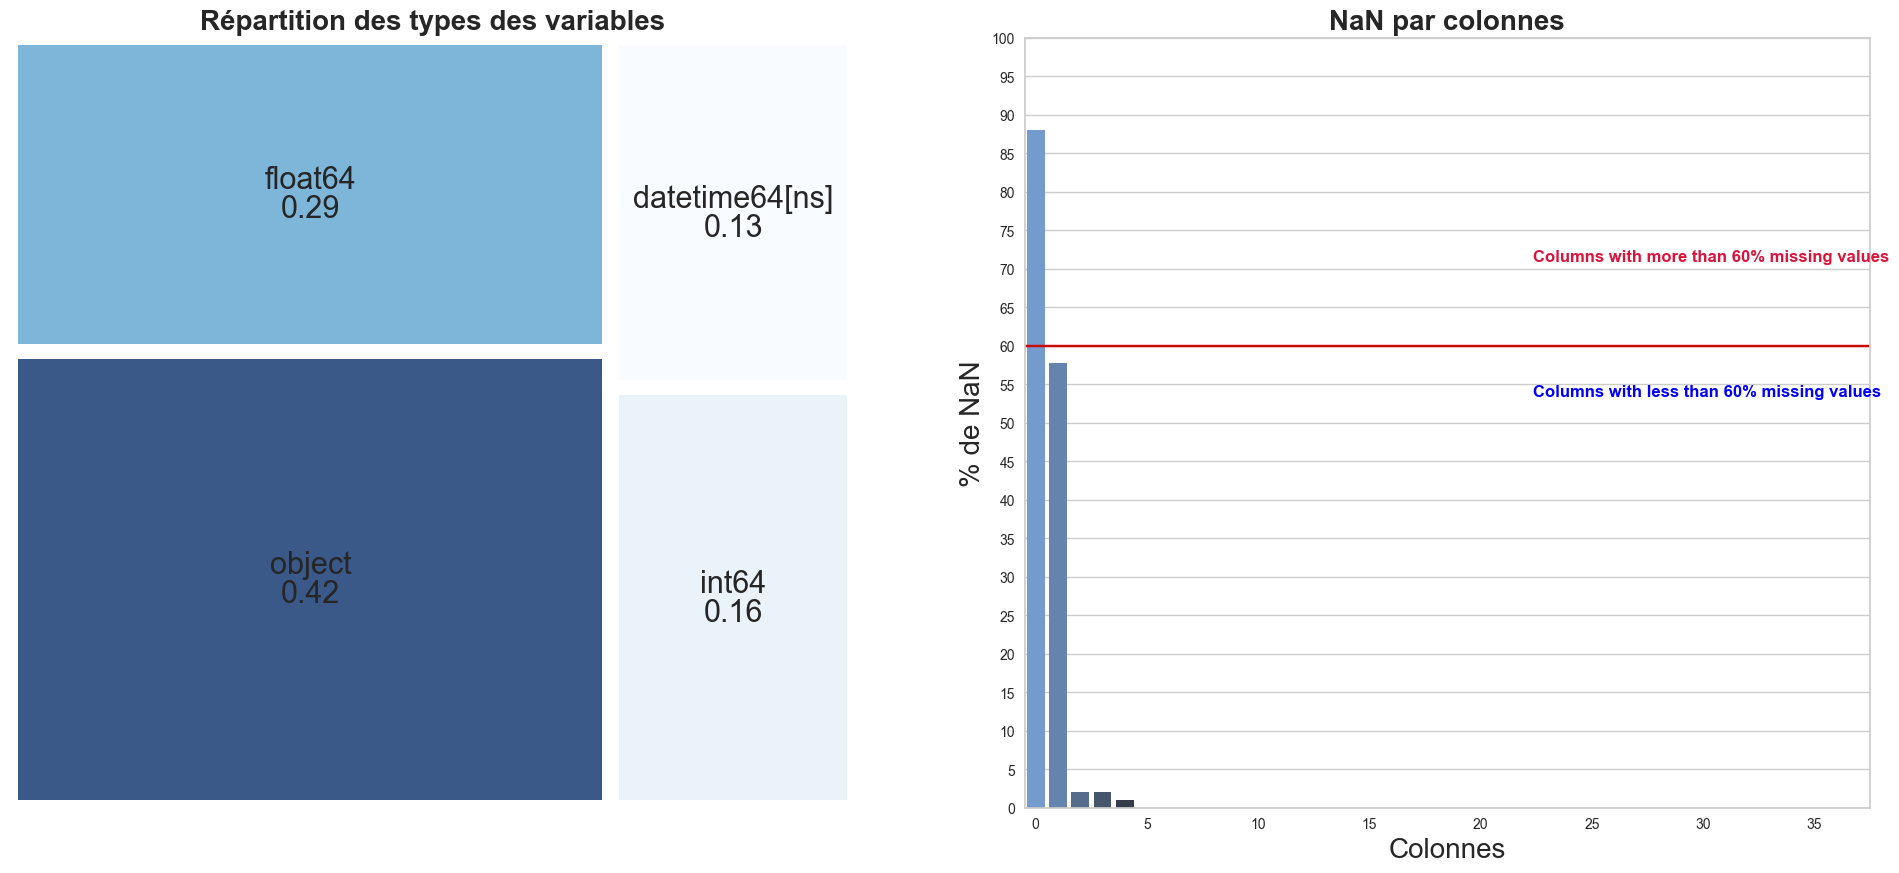

In [107]:
analyse_forme(data, figsize=(24,10), all=True)

In [108]:
data.isnull().sum()

product_id                            0
product_category_name                 0
product_name_lenght                   0
product_description_lenght            0
product_photos_qty                    0
product_weight_g                      1
product_length_cm                     1
product_height_cm                     1
product_width_cm                      1
product_category_name_english         0
order_id                              0
order_item_id                         0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
customer_total_commands               0
payment_sequential                    0
payment_type                          0
payment_installments                  0
payment_value                         0


# Feature engineering

## Transformation de variables

<AxesSubplot:xlabel='product_category_name_english'>

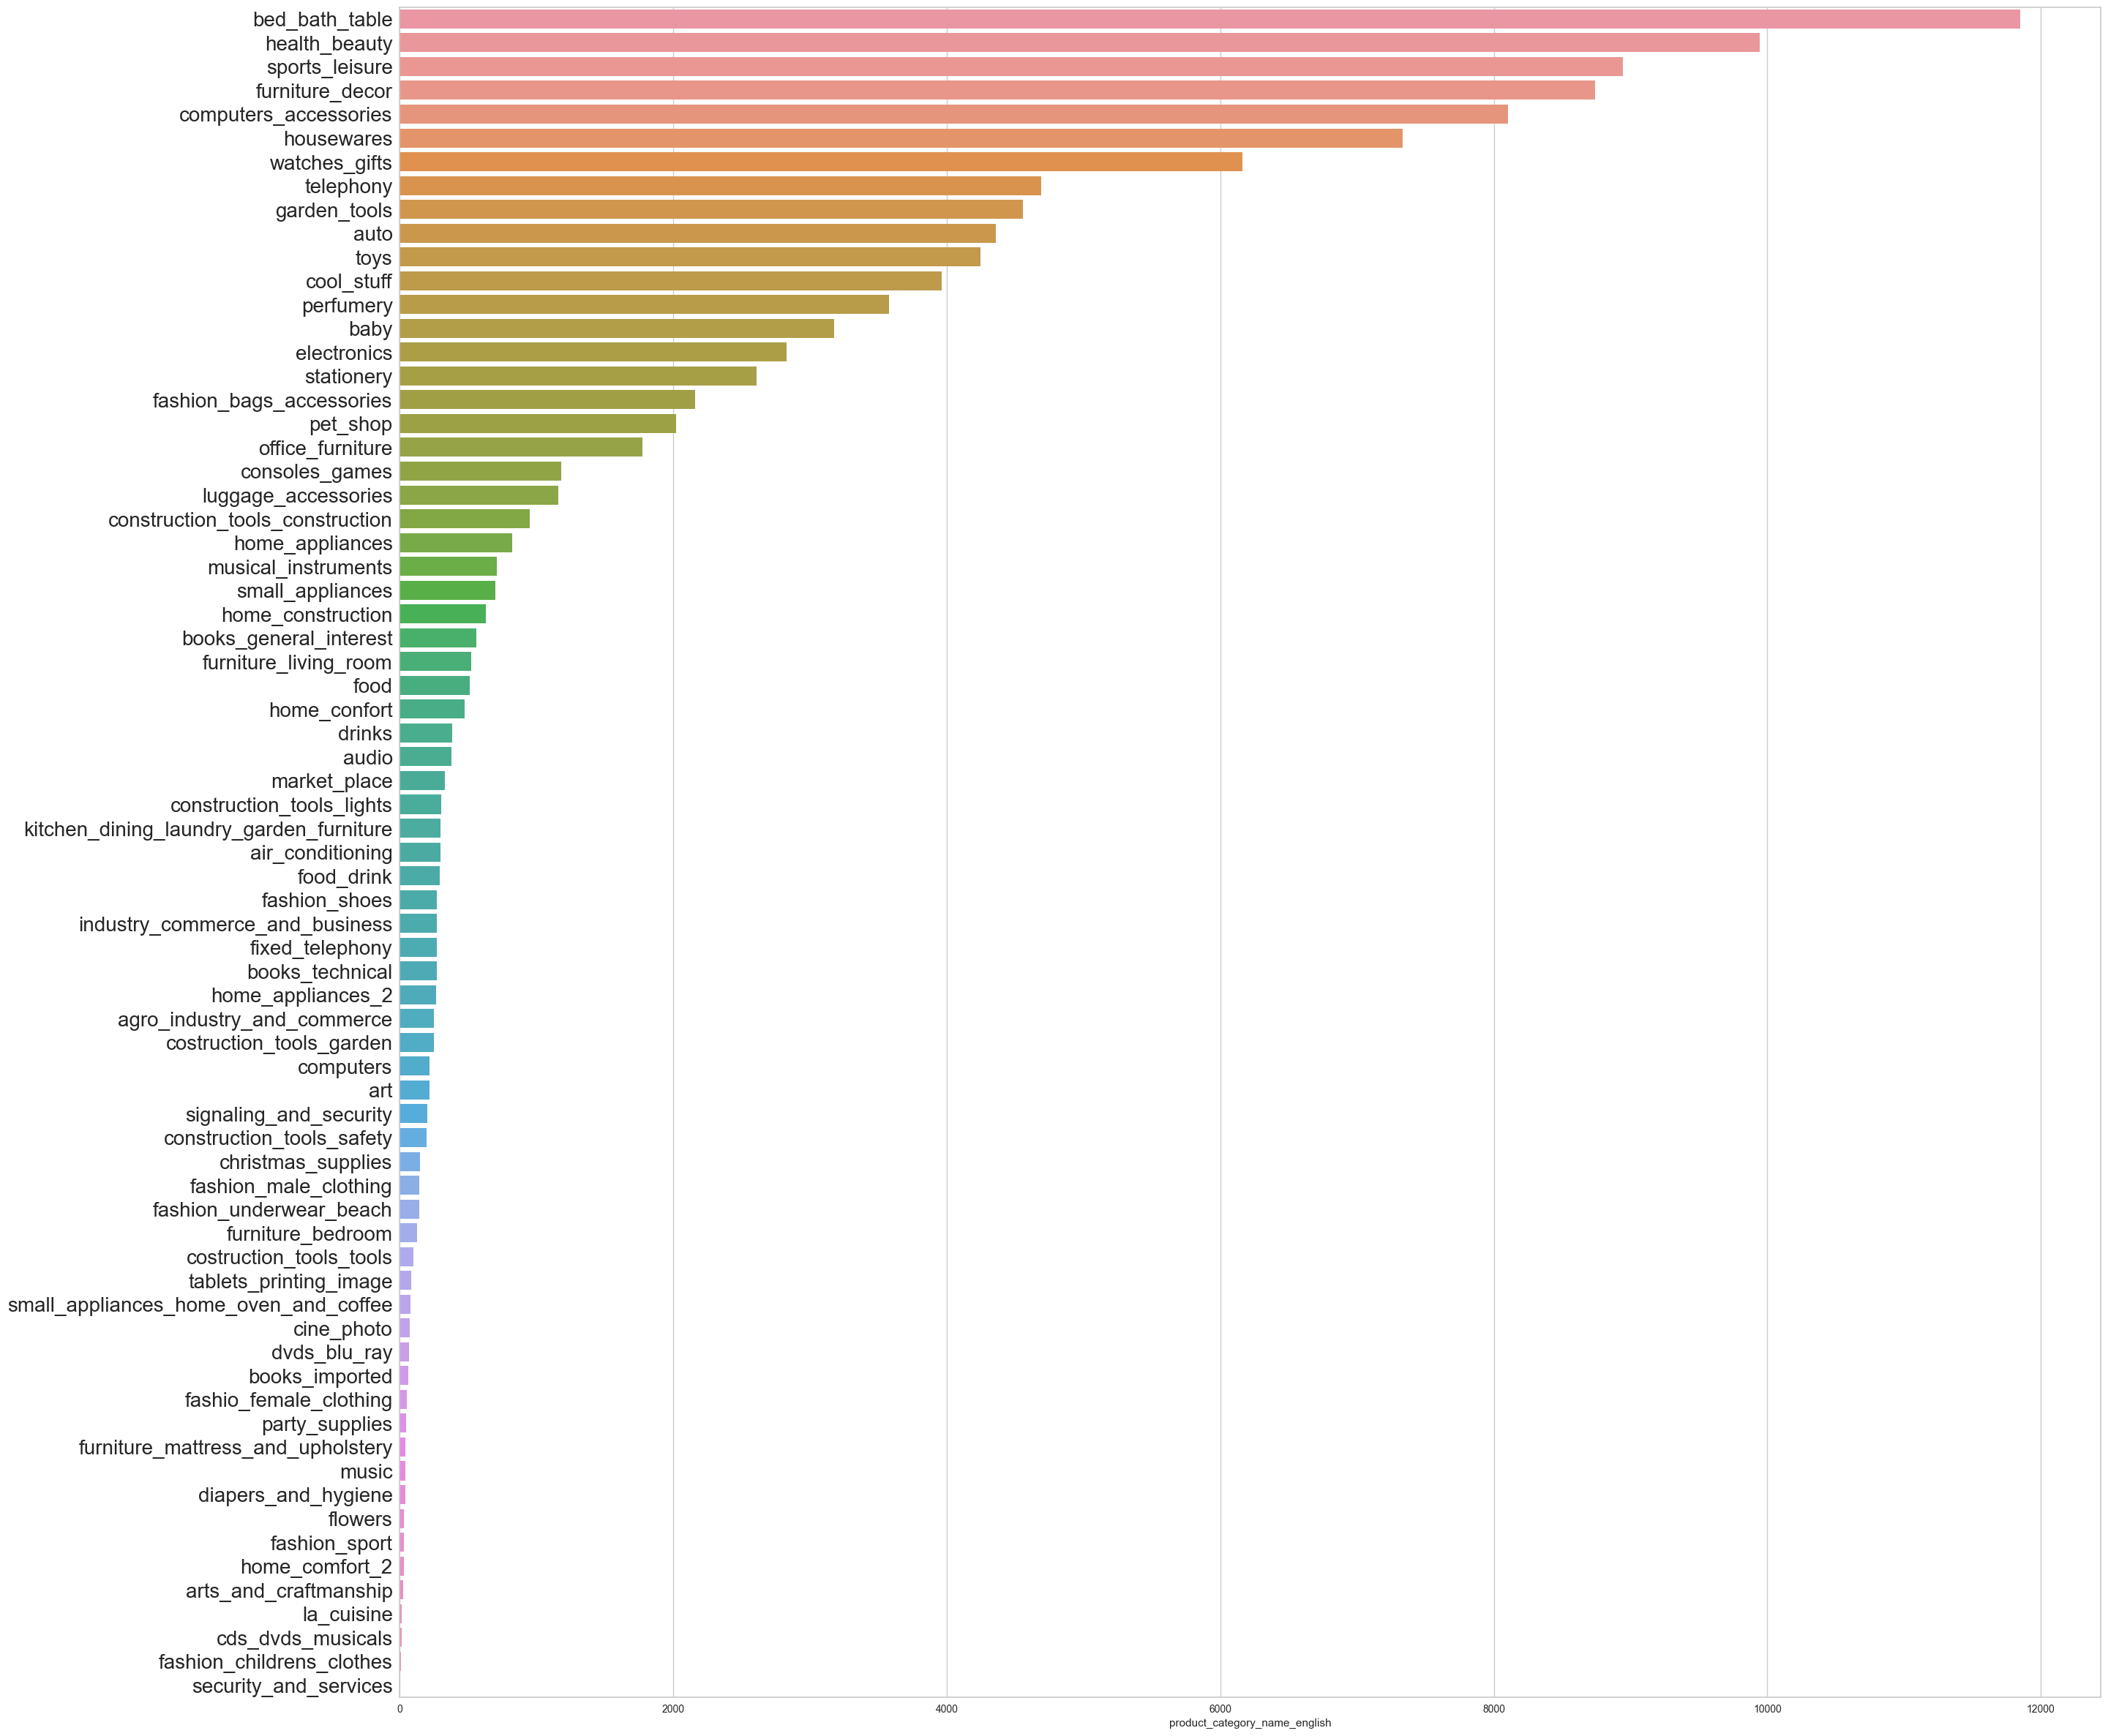

In [109]:
### Regroupement catégories en grandes catégories

# Plot columns with their number of values
sales_categ = data.product_category_name_english.value_counts()

fig, ax = plt.subplots(1,1, figsize=(30,30))
plt.yticks(size=20)

sns.barplot(y=sales_categ.index, x=sales_categ, orient="h")

In [110]:
sales_categ = dict(data.product_category_name_english.sort_values().value_counts())
dict(sorted(sales_categ.items()))

{'agro_industry_and_commerce': 252,
 'air_conditioning': 297,
 'art': 217,
 'arts_and_craftmanship': 24,
 'audio': 377,
 'auto': 4356,
 'baby': 3178,
 'bed_bath_table': 11847,
 'books_general_interest': 561,
 'books_imported': 62,
 'books_technical': 269,
 'cds_dvds_musicals': 14,
 'christmas_supplies': 148,
 'cine_photo': 74,
 'computers': 217,
 'computers_accessories': 8105,
 'consoles_games': 1180,
 'construction_tools_construction': 950,
 'construction_tools_lights': 305,
 'construction_tools_safety': 198,
 'cool_stuff': 3964,
 'costruction_tools_garden': 247,
 'costruction_tools_tools': 101,
 'diapers_and_hygiene': 39,
 'drinks': 384,
 'dvds_blu_ray': 70,
 'electronics': 2827,
 'fashio_female_clothing': 50,
 'fashion_bags_accessories': 2159,
 'fashion_childrens_clothes': 8,
 'fashion_male_clothing': 144,
 'fashion_shoes': 273,
 'fashion_sport': 31,
 'fashion_underwear_beach': 143,
 'fixed_telephony': 269,
 'flowers': 31,
 'food': 511,
 'food_drink': 290,
 'furniture_bedroom': 126,

Je me base sur la nomenclature Amazon

In [111]:
dictionnaire_items = {'agro_industry_and_commerce': "Agro",
    'air_conditioning': "Home",
    'art': "Art",
    'arts_and_craftmanship': "Art",
    'audio': "Musique_DVD",
    'auto': "Car",
    'baby': "Home",
    'bed_bath_table': "Book",
    'books_general_interest': "Book",
    'books_imported': "Book",
    'books_technical': "Book",
    'cds_dvds_musicals': "Musique_DVD",
    'christmas_supplies': "Leisure",
    'cine_photo': "Leisure",
    'computers': "Computer",
    'computers_accessories': "Computer",
    'consoles_games': "Leisure",
    'construction_tools_construction': "Construction",
    'construction_tools_lights': "Construction",
    'construction_tools_safety': "Construction",
    'cool_stuff': "Leisure",
    'costruction_tools_garden': "Construction",
    'costruction_tools_tools': "Construction",
    'diapers_and_hygiene': "Home",
    'drinks': "Home",
    'dvds_blu_ray': "Musique_DVD",
    'electronics': "Hi-tech",
    'fashio_female_clothing': "Fashion",
    'fashion_bags_accessories': "Fashion",
    'fashion_childrens_clothes': "Fashion",
    'fashion_male_clothing': "Fashion",
    'fashion_shoes': "Fashion",
    'fashion_sport': "Fashion",
    'fashion_underwear_beach': "Fashion",
    'fixed_telephony': "Hi-tech",
    'flowers': "Garden",
    'food': "Food_drink",
    'food_drink': "Food_drink",
    'furniture_bedroom': "Home",
    'furniture_decor': "Home",
    'furniture_living_room': "Home",
    'furniture_mattress_and_upholstery': "Home",
    'garden_tools': "Garden",
    'health_beauty': "Fashion",
    'home_appliances': "Home",
    'home_appliances_2': "Home",
    'home_comfort_2': "Home",
    'home_confort': "Home",
    'home_construction': "Home",
    'housewares': "Home",
    'industry_commerce_and_business': "Office",
    'kitchen_dining_laundry_garden_furniture': "Home",
    'la_cuisine': "Home",
    'luggage_accessories': "Fashion",
    'market_place': "Office",
    'music': "Musique_DVD",
    'musical_instruments': "Musique_DVD",
    'office_furniture': "Office",
    'party_supplies': "Leisure",
    'perfumery': "Fashion",
    'pet_shop': "Leisure",
    'security_and_services': "Home",
    'signaling_and_security': "Home",
    'small_appliances': "Home",
    'small_appliances_home_oven_and_coffee': "Home",
    'sports_leisure': "Leisure",
    'stationery': "Office",
    'tablets_printing_image': "Hi-tech",
    'telephony': "Hi-tech",
    'toys': "Leisure",
    'watches_gifts': "Leisure"

}

data["products"] = data.product_category_name_english.replace(dictionnaire_items)
# Ou fonction map, qui semble fonctionner directement avec un dico, comme replace

In [112]:
# Création de dummies
dummies = pd.get_dummies(data["products"], prefix="product")
data = pd.concat([data, dummies], axis=1)

## Création de nouvelles variables

In [113]:
pd.options.display.max_columns = 50 

### Ajout délai de livraison

In [114]:
 # Calcul du délai de livraison
data["delivery_delay"] = (data.order_delivered_customer_date - data.order_purchase_timestamp).dt.days

In [115]:
data.columns

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'order_id', 'order_item_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'customer_total_commands', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_delivered_delay', 'review_id',
       'review_score', 'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'products',
       'product_Agro', 'product_Art', 'product_Book', 'product_Car',

## Création des datasets

In [116]:
# Df RFM restreint

#data_rfm = data[["customer_unique_id", "order_id", "order_purchase_timestamp", "price"]]
#data_rfm_review_deliv_delay = data[["customer_unique_id", "order_id", "order_purchase_timestamp", "price", "review_score", "delivery_delay"]]

# Création d'une date repère à partir de laquelle calculer la Récence et la Fréquence
date_repere = max(data['order_purchase_timestamp']) + dt.timedelta(days=1)
print(date_repere)

# Groupby pour obtenir la Récence, la Fréquence et le Montant
rfm = data.groupby(["customer_unique_id"]).agg({\
                                            "order_purchase_timestamp": lambda x : (date_repere-x.max()).days,
                                            "order_id" : 'count',
                                            "price" : "sum"})

rfm.rename(columns={"order_purchase_timestamp": "Recency",
                            "order_id" : "Frequency",
                            "price" : "MonetaryValue"}, inplace=True)

rfm.head(3)

2018-09-04 09:06:57


,Recency,Frequency,MonetaryValue
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.9
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.9
0000f46a3911fa3c0805444483337064,542,1,69.0


In [117]:
# Df RFM + review_score + delai de livraison
rfm_review_deliv_delay = data.groupby(["customer_unique_id"]).agg({\
                                            "order_purchase_timestamp": lambda x : (date_repere-x.max()).days,
                                            "order_id" : 'count',
                                            "price" : "sum",
                                            "review_score":"mean",
                                            "delivery_delay":"mean"})

rfm_review_deliv_delay.rename(columns={"order_purchase_timestamp": "Recency",
                            "order_id" : "Frequency",
                            "price" : "MonetaryValue",
                            "review_score" : "Review",
                            "delivery_delay":"Delivery"}, inplace=True)

rfm_review_deliv_delay.head(3)

,Recency,Frequency,MonetaryValue,Review,Delivery
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.9,5.0,6.0
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.9,4.0,3.0
0000f46a3911fa3c0805444483337064,542,1,69.0,3.0,25.0


In [118]:
# Df RFM + review_score + delai de livraison + category
dummies_col = list(dummies.columns)

rfm_review_deliv_delay_categ = data.groupby(["customer_unique_id"]).agg({\
                                            "order_purchase_timestamp": lambda x : (date_repere-x.max()).days,
                                            "order_id" : 'count',
                                            "price" : "sum",
                                            "review_score":"mean",
                                            "delivery_delay":"mean",
                                            **{col: "mean" for col in dummies_col}})

rfm_review_deliv_delay_categ.rename(columns={"order_purchase_timestamp": "Recency",
                            "order_id" : "Frequency",
                            "price" : "MonetaryValue",
                            "review_score" : "Review",
                            "delivery_delay":"Delivery"}, inplace=True)

rfm_review_deliv_delay_categ.head(3)

,Recency,Frequency,MonetaryValue,Review,Delivery,product_Agro,product_Art,product_Book,product_Car,product_Computer,product_Construction,product_Fashion,product_Food_drink,product_Garden,product_Hi-tech,product_Home,product_Leisure,product_Musique_DVD,product_Office
customer_unique_id,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.9,5.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.9,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000f46a3911fa3c0805444483337064,542,1,69.0,3.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


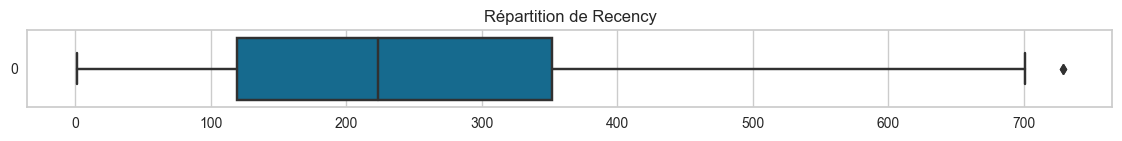

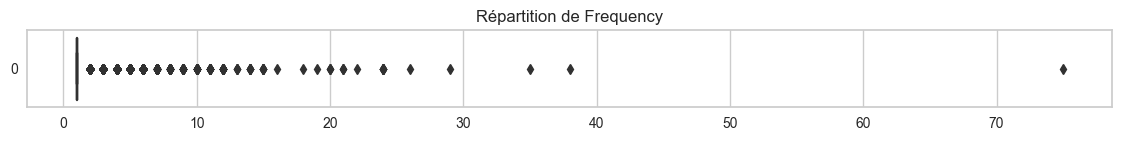

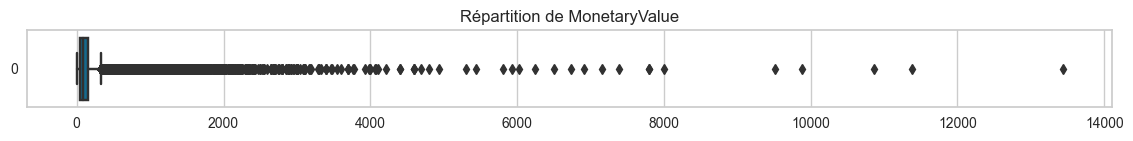

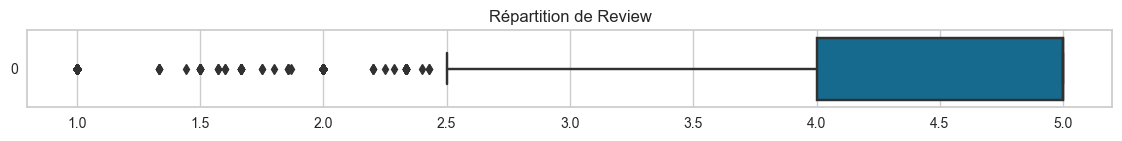

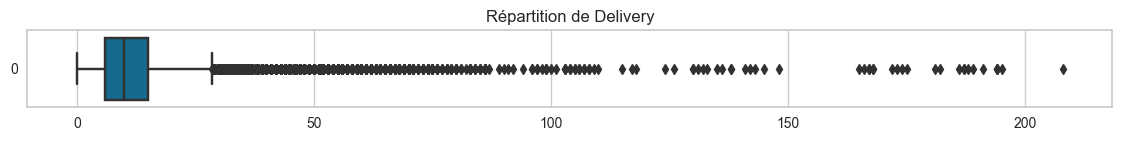

In [119]:
# Gestion des outliers (pas d'outliers sur le dernier dataset, auquel on n'a ajouté que des booléens)
# Boxplots pour observer la présence d'outliers.

for column in rfm_review_deliv_delay.columns:
    plt.figure(figsize=(14,1))
    sns.boxplot(rfm_review_deliv_delay[column], orient = "h")
    plt.title(f"Répartition de {column}")
    plt.show()

In [120]:
# Suppression outliers

THRESHOLD_OUTLIER_RECENCY = 700
THRESHOLD_OUTLIER_FREQUENCY = 30
THRESHOLD_OUTLIER_MONETARY_VALUE = 8000
THRESHOLD_REVIEW = 2
THRESHOLD_DELIVERY = 1*10e7

rfm = rfm.loc[(rfm.Recency <= THRESHOLD_OUTLIER_RECENCY)
                            & (rfm.Frequency <= THRESHOLD_OUTLIER_FREQUENCY)
                            & (rfm.MonetaryValue <= THRESHOLD_OUTLIER_MONETARY_VALUE)]

rfm_review_deliv_delay = rfm_review_deliv_delay.loc[(rfm_review_deliv_delay.Recency <= THRESHOLD_OUTLIER_RECENCY)
                            & (rfm_review_deliv_delay.Frequency <= THRESHOLD_OUTLIER_FREQUENCY)
                            & (rfm_review_deliv_delay.MonetaryValue <= THRESHOLD_OUTLIER_MONETARY_VALUE)
                            & (rfm_review_deliv_delay.Review > THRESHOLD_REVIEW)
                            & (rfm_review_deliv_delay.Delivery < THRESHOLD_DELIVERY)]

## K-Means

POUR MOI  
On veut que la variance intra de chaque cluster soit très faible, et que la variance extra soit très élevée. Et le score calinski_harabasz est le ratio de la variance intra sur la variance inter.

# Clustering

## RFM

**Silhouette score (A maximiser)**: Différence entre la distance moyenne avec les points du même groupe que lui (**cohésion**) et la distance moyenne avec les points des autres groupes voisins (**séparation**).<br>
**Calinski_Harabasz score (A maximiser)**: Rapport entre la variance inter-groupes et la variance intra-groupe.  <br> 
**Davies_Bouldin score (A minimiser)**: Moyenne du rapport maximal entre la distance d'un point au centre de son groupe et la distance entre deux centres de groupes <br>
**Distortion (Trouver coude)**: Moyenne de la somme des distances au carré point-centroide. <br>

In [121]:
scores_rfm = compute_clust_scores_nclust(KMeans(), rfm, n_iter=1, num_clusters=range(3,11))

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning:

All-NaN axis encountered

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning:

All-NaN axis encountered



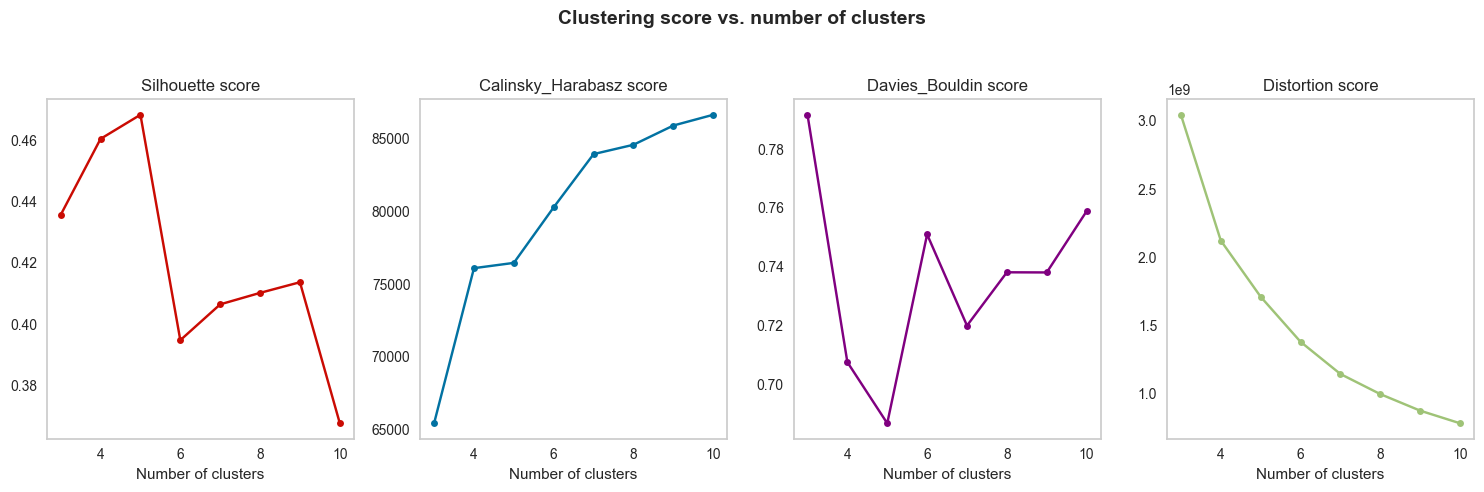

In [122]:
plot_scores_vs_n_clust(scores_rfm, figsize=(15,5))

De par ces résultats, **le nb de clusters le plus adapté est 5**.

In [123]:
scores_rfm_time = compute_clust_scores_nclust_time(KMeans(), rfm, n_iter=1, num_clusters=range(3,11))

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning:

All-NaN axis encountered

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning:

All-NaN axis encountered



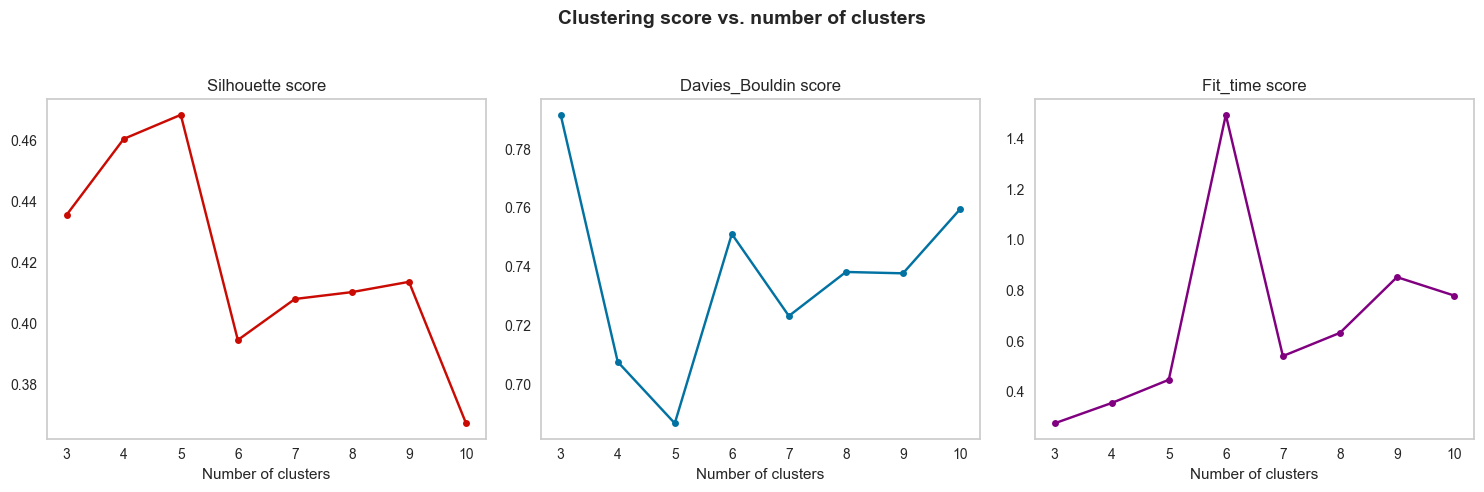

In [124]:
plot_scores_vs_n_clust_time(scores_rfm_time, figsize=(15,5))

POUR MOI  
https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html
Etude silhouette : vérif tous les silhouette_score de chaque cluster dépassent la barre rouge --> permet de dire si telle ou telle méthode est bonne.

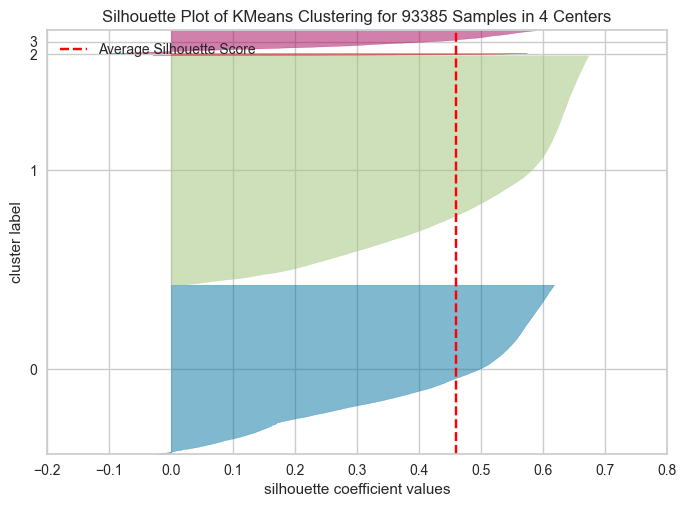

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 93385 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [125]:
# Instantiate a KMeans clustering model
model = KMeans(n_clusters=4, random_state=42)

# Instantiate a silhouette visualizer with 4 clusters
visualizer = SilhouetteVisualizer(estimator=model, colors='yellowbrick', n_clusters=4)

# Fit the visualizer to your data
visualizer.fit(rfm)

# Render the visualization
visualizer.show()

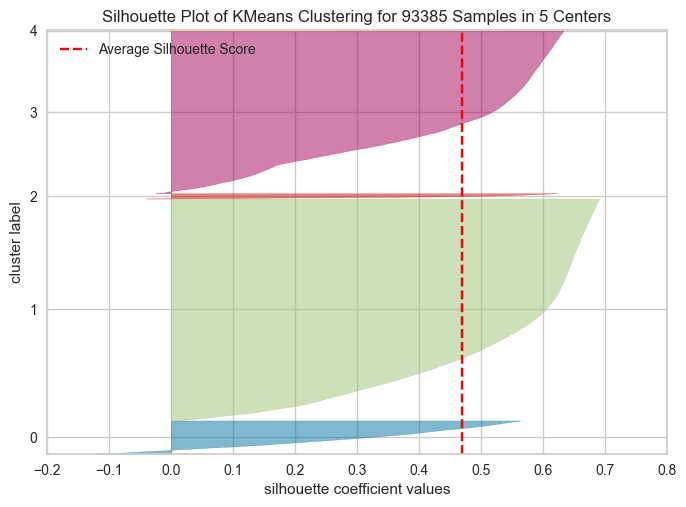

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 93385 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [126]:
# Instantiate a KMeans clustering model
model = KMeans(n_clusters=5, random_state=42)

# Instantiate a silhouette visualizer with 5 clusters
visualizer = SilhouetteVisualizer(estimator=model, colors='yellowbrick', n_clusters=5)

# Fit the visualizer to your data
visualizer.fit(rfm)

# Render the visualization
visualizer.show()

Profils des clients

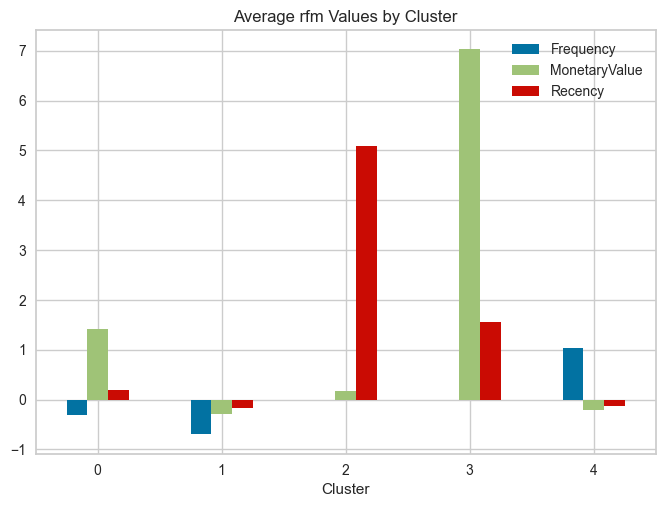

In [127]:
# Fit the KMeans model with the optimal number of clusters
kmeans = KMeans(n_clusters=5, random_state=42)
rfm_scaled = StandardScaler().fit_transform(rfm)
kmeans.fit(rfm_scaled)

# Assign each customer to a cluster
variables = ["Frequency", "MonetaryValue", "Recency"]
rfm_clustered = pd.DataFrame(rfm_scaled.copy(), columns=variables)
rfm_clustered['cluster_kmeans'] = kmeans.labels_

# Calculate the average rfm values for each cluster
rfm_clustered.groupby('cluster_kmeans').mean()

# Create a bar chart of the average rfm values for each cluster
rfm_clustered.groupby('cluster_kmeans').mean().plot(kind='bar')
plt.title('Average rfm Values by Cluster')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

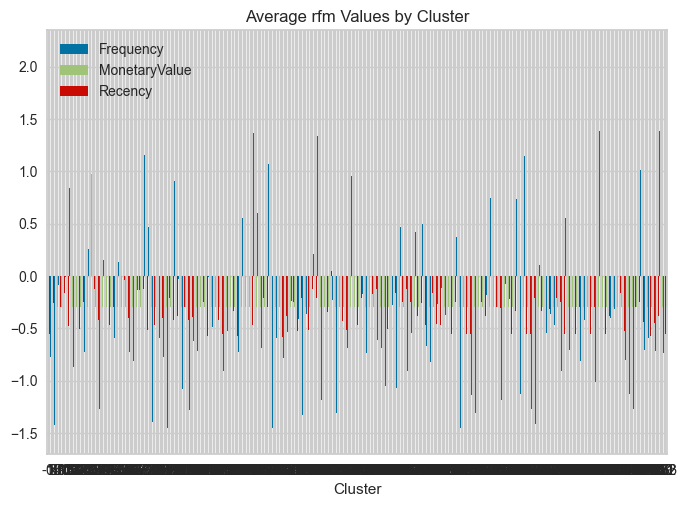

In [128]:
# DBSCAN
X = rfm_scaled.copy()

# Instancier la classe DBSCAN
dbscan = DBSCAN(eps=0.01, min_samples = (len(X)/5000))

# Appliquer l'algorithme DBSCAN sur les données
dbscan.fit(X)

# Identifier les clusters résultants
labels = dbscan.labels_

# Create new column with the labels
rfm_clustered["cluster_dbscan"] = labels

# Create a bar chart of the average rfm values for each cluster
rfm_clustered.drop(columns="cluster_kmeans").groupby('cluster_dbscan').mean().plot(kind='bar')
plt.title('Average rfm Values by Cluster')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

Bcp trop de clusters : DBScans pas fonctionnel.

In [129]:
# Calculer l'indice de silhouette
silhouette = silhouette_score(X, labels)
print("Indice de silhouette :", silhouette)

# Calculer l'indice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(X, labels)
print("Indice de Davies-Bouldin :", davies_bouldin)

# Générer un regroupement aléatoire pour comparer les résultats
random_labels = np.random.randint(0, 3, size=len(X))
silhouette_random = silhouette_score(X, random_labels)
davies_bouldin_random = davies_bouldin_score(X, random_labels)
print("Indice de silhouette pour un regroupement aléatoire :", silhouette_random)
print("Indice de Davies-Bouldin pour un regroupement aléatoire :", davies_bouldin_random)

Indice de silhouette : -0.49597837089190966
Indice de Davies-Bouldin : 1.5859941040470513
Indice de silhouette pour un regroupement aléatoire : -0.005033864212123042
Indice de Davies-Bouldin pour un regroupement aléatoire : 183.13517535489368


In [130]:
from scipy.cluster.hierarchy import linkage
from sklearn.preprocessing import StandardScaler

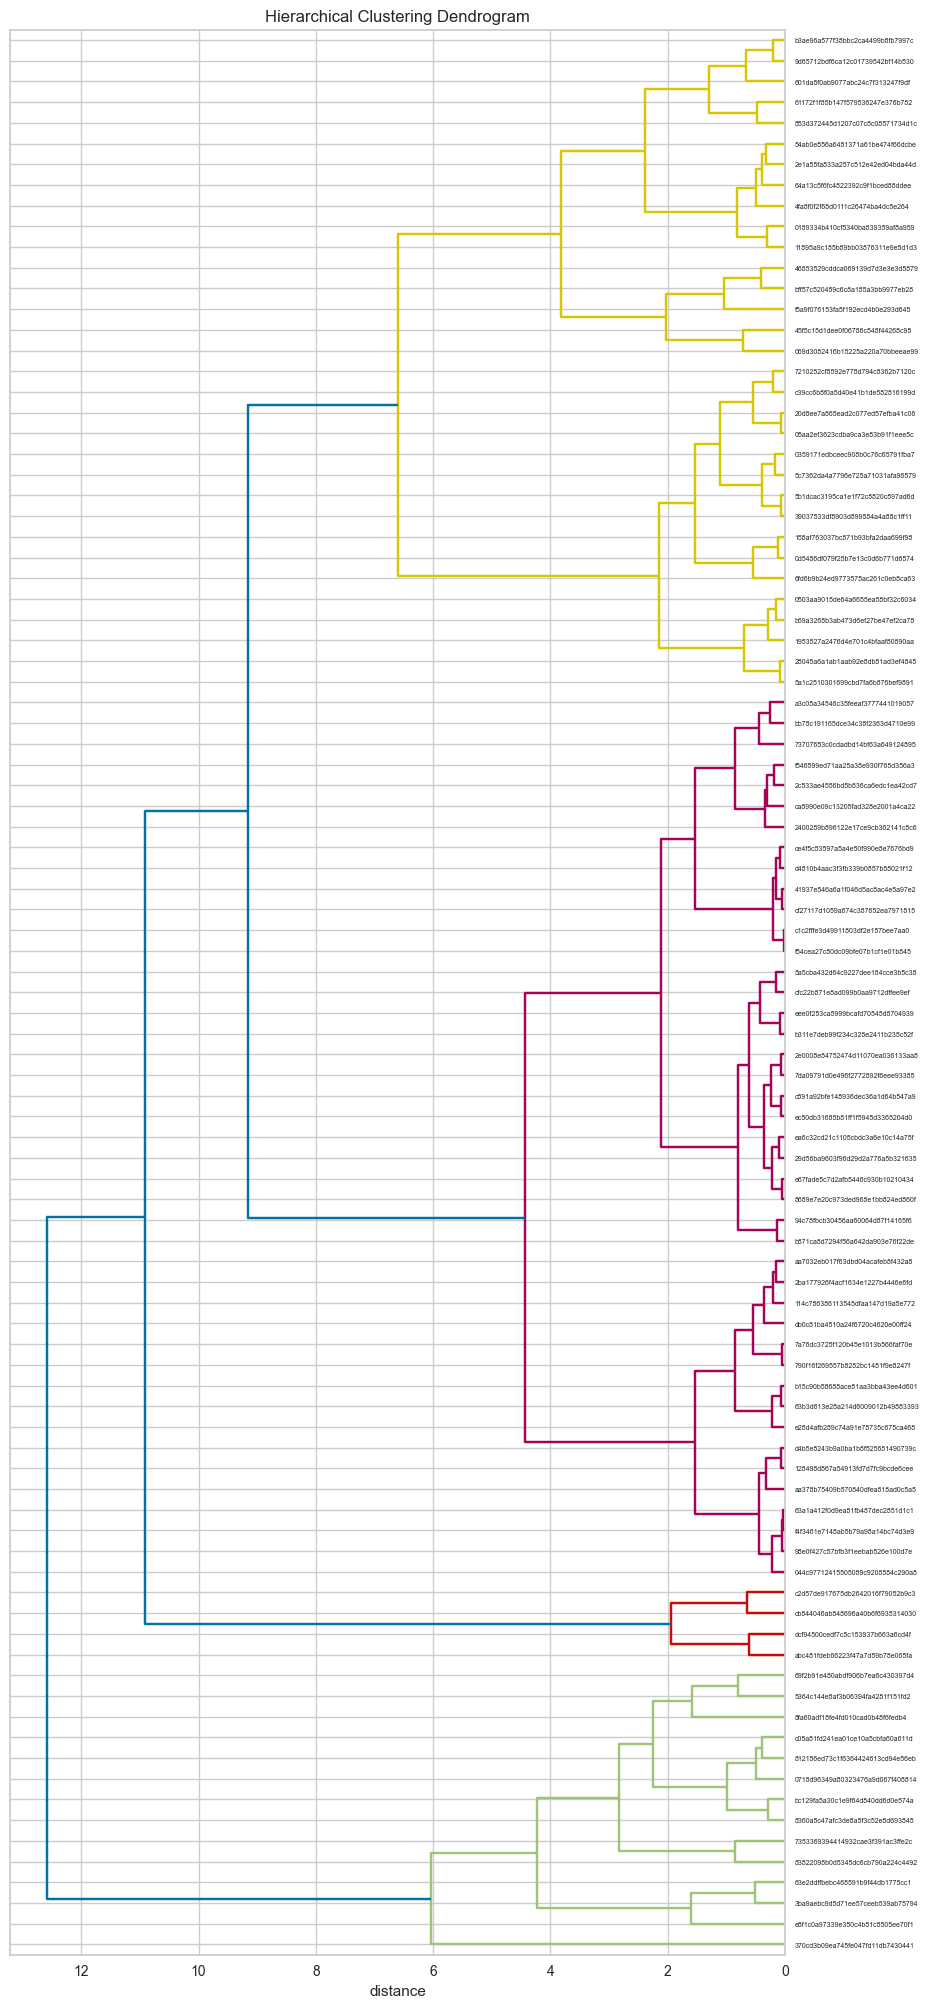

In [131]:
# Agglomerative clustering / Dendrogramme

# Préparation des données pour le clustering
dendrogramme = rfm.sample(n=round((len(rfm)/1000))) # Echantillon car sinon df trop important
X = dendrogramme.values
names = dendrogramme.index

# Centrage et Réduction
std_scale = StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z, names)

In [132]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
variables = ["Frequency", "MonetaryValue", "Recency"]

# Créer un dataframe pour chaque cluster
clusters = rfm_clustered.groupby('cluster_kmeans')

# Récupérer les noms des clusters
cluster_names = rfm_clustered['cluster_kmeans'].unique()

# Créer une figure Plotly avec 6 sous-figures polar
fig = make_subplots(rows=2, cols=3, subplot_titles=[f'Cluster {name}' for name in cluster_names], specs=[[{'type': 'polar'}]*3]*2, horizontal_spacing=0.001, vertical_spacing=0.2)

# Parcourir les clusters et ajouter un radar plot à chaque sous-figure
for i, cluster in enumerate(clusters):
    data11 = cluster[1][variables].mean().values.flatten().tolist()
    data11 += data11[:1]

    fig.add_trace(go.Scatterpolar(
        r=data11,
        theta=variables + [variables[0]],
        fill='toself',
        name=f'Cluster {cluster_names[i]}'
    ), row=(i // 3) + 1, col=(i % 3) + 1)

    # Ajouter les étiquettes des axes pour chaque sous-figure
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            ),
        ),
        showlegend=True,
        width=1800,
        height=900
    )

# Mettre à jour le titre de la figure
fig.update_layout(title_text='Radar plot des clusters')

# Afficher la figure
fig.show()

# Create the radar chart using Plotly Express
for cluster in radar_norm_grouped.index:
    fig = px.line_polar(radar_norm, r=radar_norm.iloc[cluster].values(), theta=radar_labels, line_close=True, 
                    width=700, height=500, range_r=[0, 1], title='Radar Chart of Integer Variables')
    # Add a second line to the chart for comparison, using the maximum values for each column
    fig.add_trace(px.line_polar(r=radar_max, theta=radar_labels, line_close=True).data[0])
    # Show the radar chart
    fig.show()

In [133]:
import joblib
joblib.dump(rfm, "rfm_dataset")

['rfm_dataset']

## RFM + deliv + delay

In [134]:
# A METTRE AUTRE PART ? AVANT ?

In [135]:
nan_mask = rfm_review_deliv_delay["Delivery"].isna()
nan_values = rfm_review_deliv_delay.loc[nan_mask, 'Delivery']
print(nan_values)

Series([], Name: Delivery, dtype: float64)


In [136]:
#rfm_review_deliv_delay["Delivery"] = rfm_review_deliv_delay["Delivery"].dt.total_seconds()
# ERREUR TEMP - CORRIGER AVEC METHODE MICE 
rfm_review_deliv_delay["Delivery"] = rfm_review_deliv_delay["Delivery"].fillna(0)

In [137]:
rfm_review_deliv_delay

,Recency,Frequency,MonetaryValue,Review,Delivery
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,5.0,6.0
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4.0,3.0
0000f46a3911fa3c0805444483337064,542,1,69.00,3.0,25.0
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,4.0,20.0
0004aac84e0df4da2b147fca70cf8255,293,1,180.00,5.0,13.0
...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,452,2,1570.00,5.0,27.0
fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89,4.0,30.0
ffff371b4d645b6ecea244b27531430a,573,1,89.90,5.0,14.0


In [138]:
scores_rfm_review_deliv_delay = compute_clust_scores_nclust(KMeans(), rfm_review_deliv_delay, n_iter=1, num_clusters=range(3,11))
plot_scores_vs_n_clust(scores_rfm_review_deliv_delay, figsize=(15,5))

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning:

All-NaN axis encountered

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning:

All-NaN axis encountered



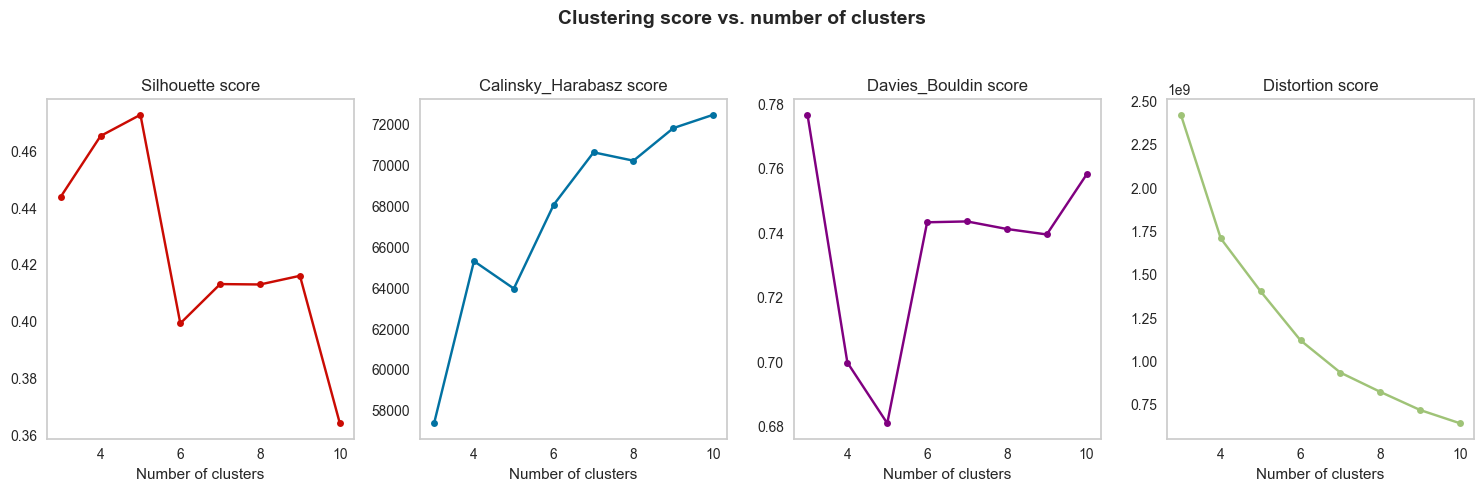

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning:

All-NaN axis encountered

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning:

All-NaN axis encountered



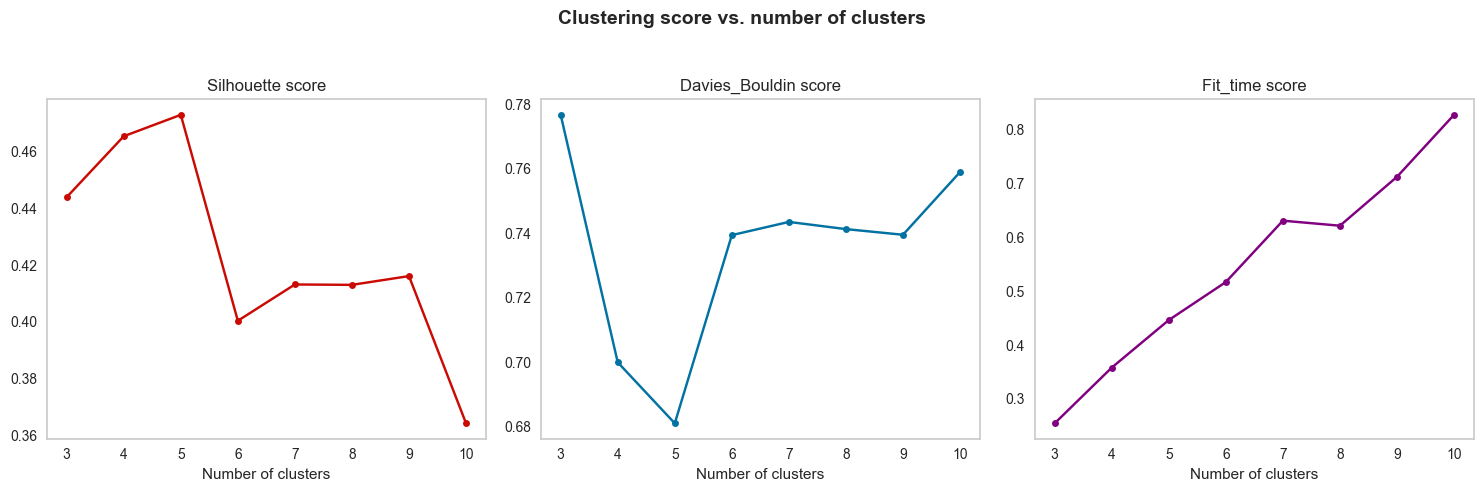

In [140]:
scores_rfm_review_deliv_delay_time = compute_clust_scores_nclust_time(KMeans(), rfm_review_deliv_delay, n_iter=1, num_clusters=range(3,11))
plot_scores_vs_n_clust_time(scores_rfm_review_deliv_delay_time, figsize=(15,5))

De par ces résultats, **le nb de clusters le plus adapté est 5**.

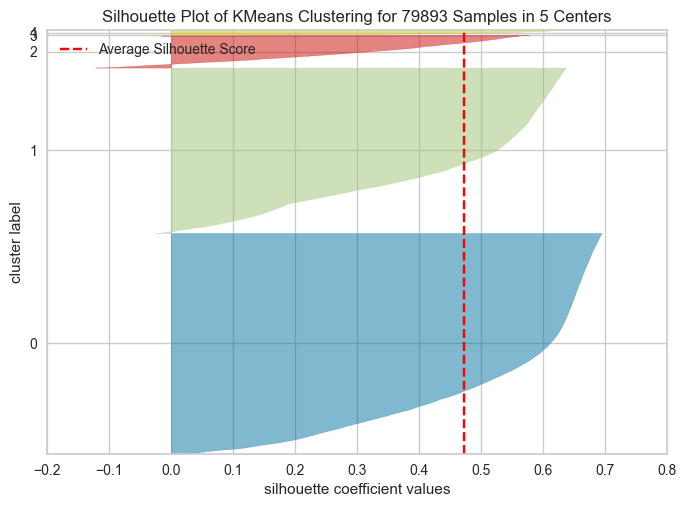

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 79893 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [141]:
# Instantiate a KMeans clustering model
model = KMeans(n_clusters=5, random_state=42)

# Instantiate a silhouette visualizer with 4 clusters
visualizer = SilhouetteVisualizer(estimator=model, colors='yellowbrick', n_clusters=4)

# Fit the visualizer to your data
visualizer.fit(rfm_review_deliv_delay)

# Render the visualization
visualizer.show()

Profils des clients

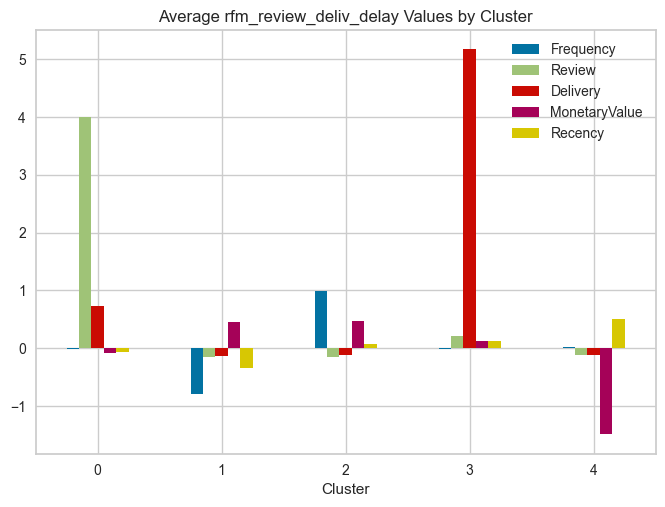

In [143]:
# Fit the KMeans model with the optimal number of clusters
kmeans = KMeans(n_clusters=5, random_state=42)
rfm_review_deliv_delay_scaled = StandardScaler().fit_transform(rfm_review_deliv_delay)
kmeans.fit(rfm_review_deliv_delay_scaled)

# Assign each customer to a cluster
variables = ["Frequency", "Review", "Delivery", "MonetaryValue", "Recency"]
rfm_review_deliv_delay_clustered = pd.DataFrame(rfm_review_deliv_delay_scaled.copy(), columns=variables)
rfm_review_deliv_delay_clustered['cluster_kmeans'] = kmeans.labels_

# Calculate the average rfm_review_deliv_delay values for each cluster
rfm_review_deliv_delay_clustered.groupby('cluster_kmeans').mean()

# Create a bar chart of the average rfm_review_deliv_delay values for each cluster
rfm_review_deliv_delay_clustered.groupby('cluster_kmeans').mean().plot(kind='bar')
plt.title('Average rfm_review_deliv_delay Values by Cluster')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

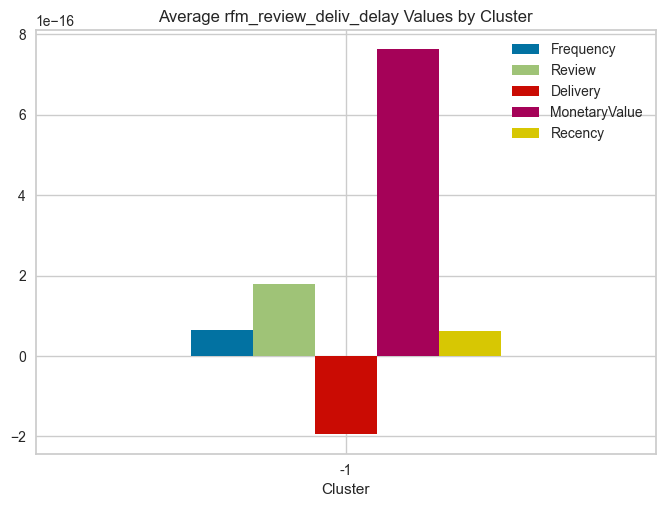

In [144]:
# DBSCAN
X = rfm_review_deliv_delay_scaled.copy()

# Instancier la classe DBSCAN
dbscan = DBSCAN(eps=0.01, min_samples = (len(X)/5000))

# Appliquer l'algorithme DBSCAN sur les données
dbscan.fit(X)

# Identifier les clusters résultants
labels = dbscan.labels_

# Create new column with the labels
rfm_review_deliv_delay_clustered["cluster_dbscan"] = labels

# Create a bar chart of the average rfm_review_deliv_delay values for each cluster
rfm_review_deliv_delay_clustered.drop(columns="cluster_kmeans").groupby('cluster_dbscan').mean().plot(kind='bar')
plt.title('Average rfm_review_deliv_delay Values by Cluster')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

Le DBScan classifie très mal.

In [145]:
# Calculer l'indice de silhouette
silhouette = silhouette_score(X, labels)
print("Indice de silhouette :", silhouette)

# Calculer l'indice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(X, labels)
print("Indice de Davies-Bouldin :", davies_bouldin)

# Générer un regroupement aléatoire pour comparer les résultats
random_labels = np.random.randint(0, 3, size=len(X))
silhouette_random = silhouette_score(X, random_labels)
davies_bouldin_random = davies_bouldin_score(X, random_labels)
print("Indice de silhouette pour un regroupement aléatoire :", silhouette_random)
print("Indice de Davies-Bouldin pour un regroupement aléatoire :", davies_bouldin_random)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

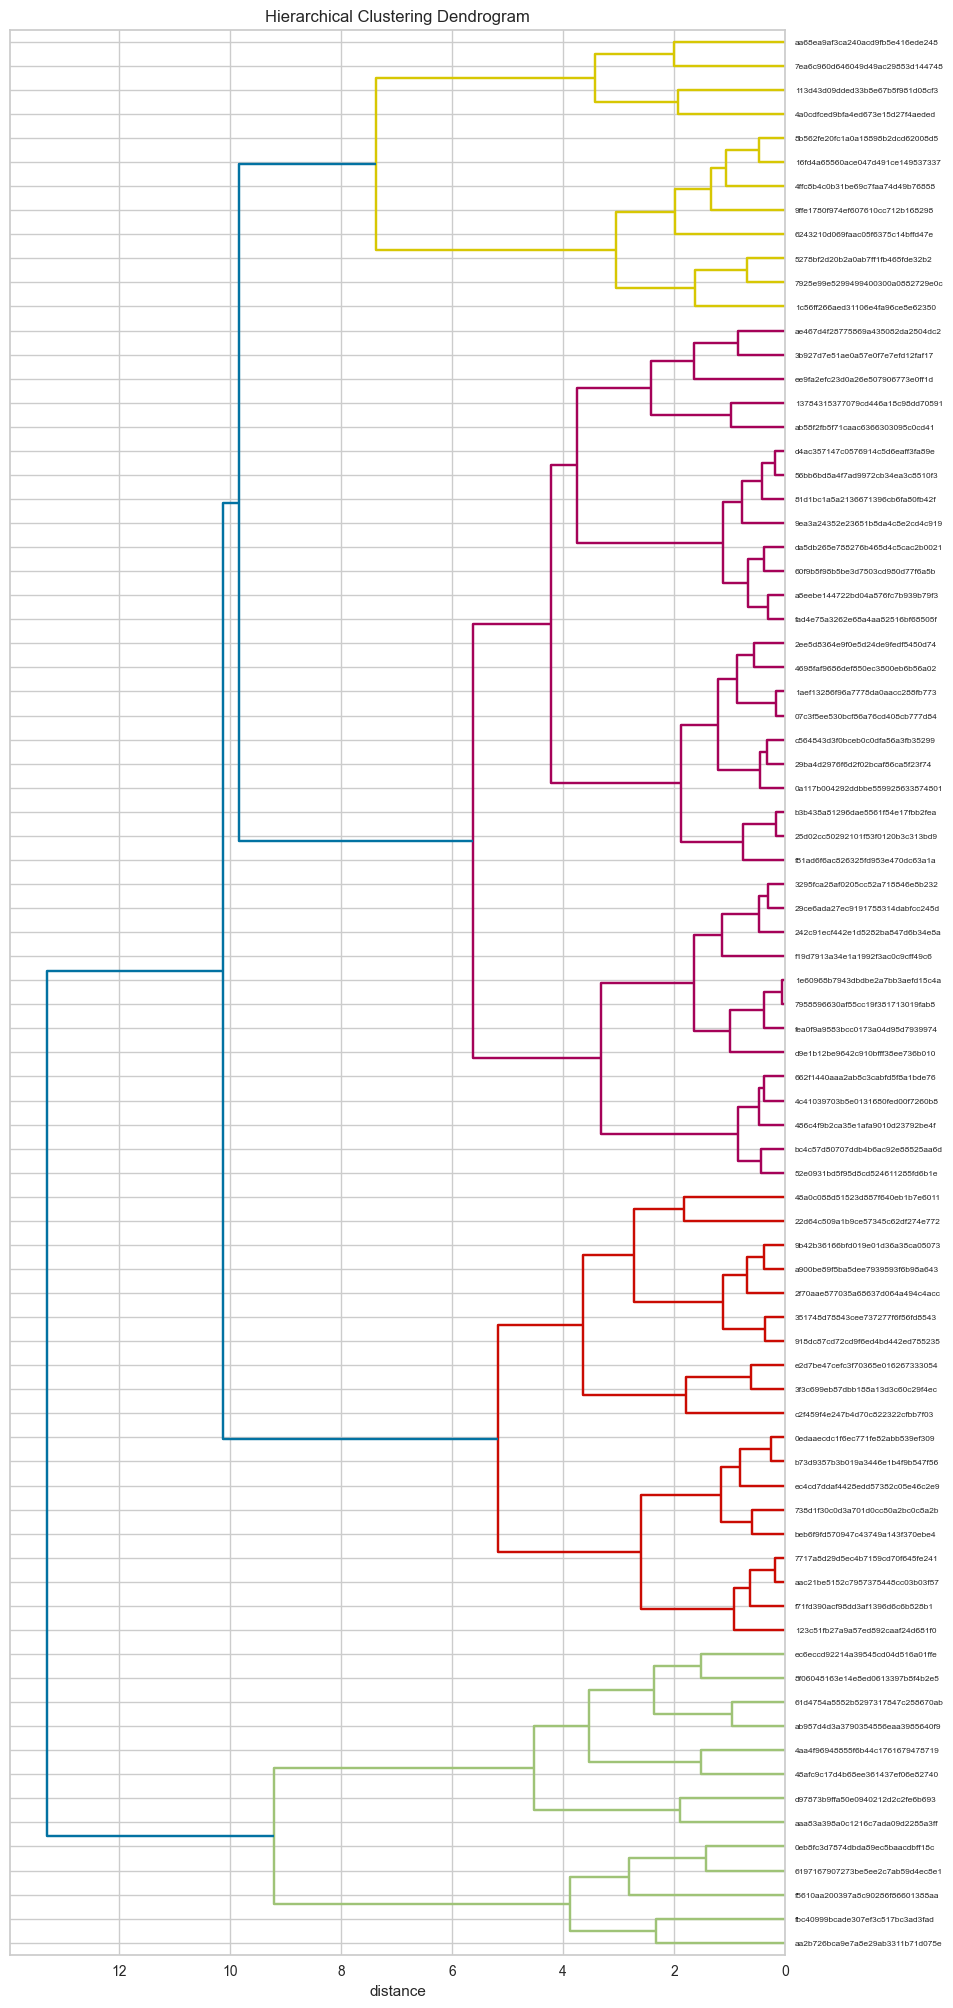

In [146]:
# Agglomerative clustering / Dendrogramme

# Préparation des données pour le clustering
dendrogramme = rfm_review_deliv_delay.sample(n=round((len(rfm_review_deliv_delay)/1000))) # Echantillon car sinon df trop important
X = dendrogramme.values
names = dendrogramme.index

# Centrage et Réduction
std_scale = StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z, names)

MinMaxScaler aurait été plus adapté pour les radar plots mais il est trop sensible aux outliers, et on en a bcp ici. On garde le dataframe produit plus tôt avec le StandardScaler.

In [147]:
variables = ["Frequency", "Review", "Delivery", "MonetaryValue", "Recency"]

# Créer un dataframe pour chaque cluster
clusters = rfm_review_deliv_delay_clustered.groupby('cluster_kmeans')

# Récupérer les noms des clusters
cluster_names = rfm_review_deliv_delay_clustered['cluster_kmeans'].unique()

# Créer une figure Plotly avec 6 sous-figures polar
fig = make_subplots(rows=2, cols=3, subplot_titles=[f'Cluster {name}' for name in cluster_names], specs=[[{'type': 'polar'}]*3]*2, horizontal_spacing=0.001, vertical_spacing=0.2)

# Parcourir les clusters et ajouter un radar plot à chaque sous-figure
for i, cluster in enumerate(clusters):
    data11 = cluster[1][variables].mean().values.flatten().tolist()
    data11 += data11[:1]

    fig.add_trace(go.Scatterpolar(
        r=data11,
        theta=variables + [variables[0]],
        fill='toself',
        name=f'Cluster {cluster_names[i]}'
    ), row=(i // 3) + 1, col=(i % 3) + 1)

    # Ajouter les étiquettes des axes pour chaque sous-figure
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            ),
        ),
        showlegend=True,
        width=1800,
        height=900
    )

# Mettre à jour le titre de la figure
fig.update_layout(title_text='Radar plot des clusters')

# Afficher la figure
fig.show()

In [148]:
joblib.dump(rfm_review_deliv_delay, "rfm_review_deliv_delay_dataset")

['rfm_review_deliv_delay_dataset']

## RFM + deliv + delay + categ

In [149]:
# ERREUR TEMP - CORRIGER AVEC METHODE MICE 
rfm_review_deliv_delay_categ["Delivery"] = rfm_review_deliv_delay_categ["Delivery"].fillna(0)

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning:

All-NaN axis encountered

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning:

All-NaN axis encountered



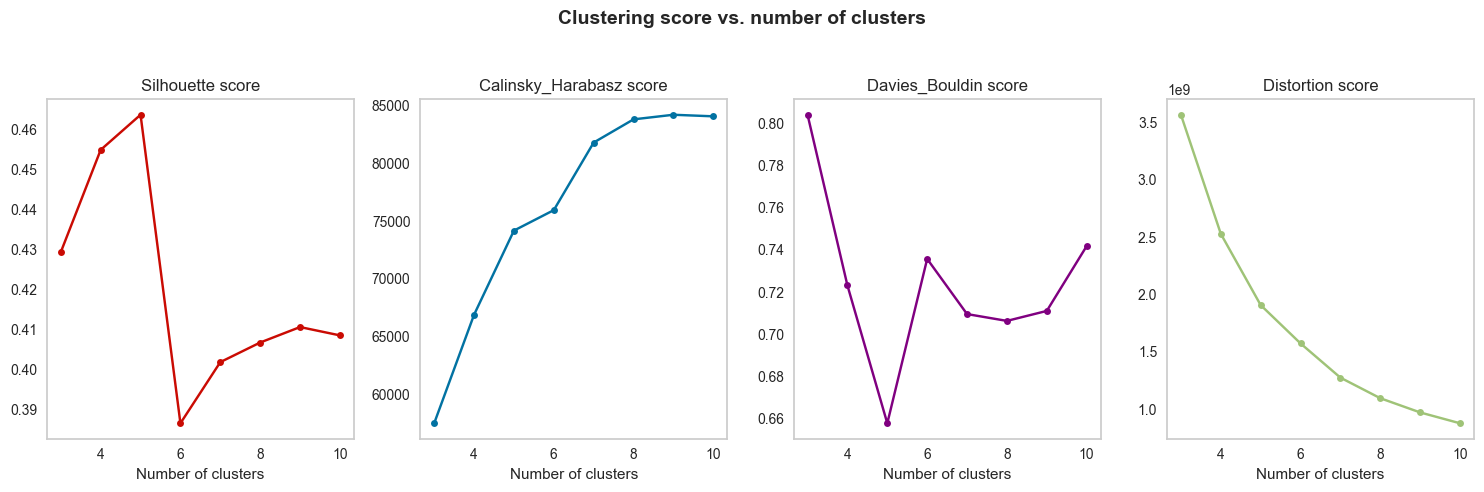

In [150]:
scores_rfm_review_deliv_delay_categ = compute_clust_scores_nclust(KMeans(), rfm_review_deliv_delay_categ, n_iter=1, num_clusters=range(3,11))
plot_scores_vs_n_clust(scores_rfm_review_deliv_delay_categ, figsize=(15,5))

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning:

All-NaN axis encountered

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning:

All-NaN axis encountered



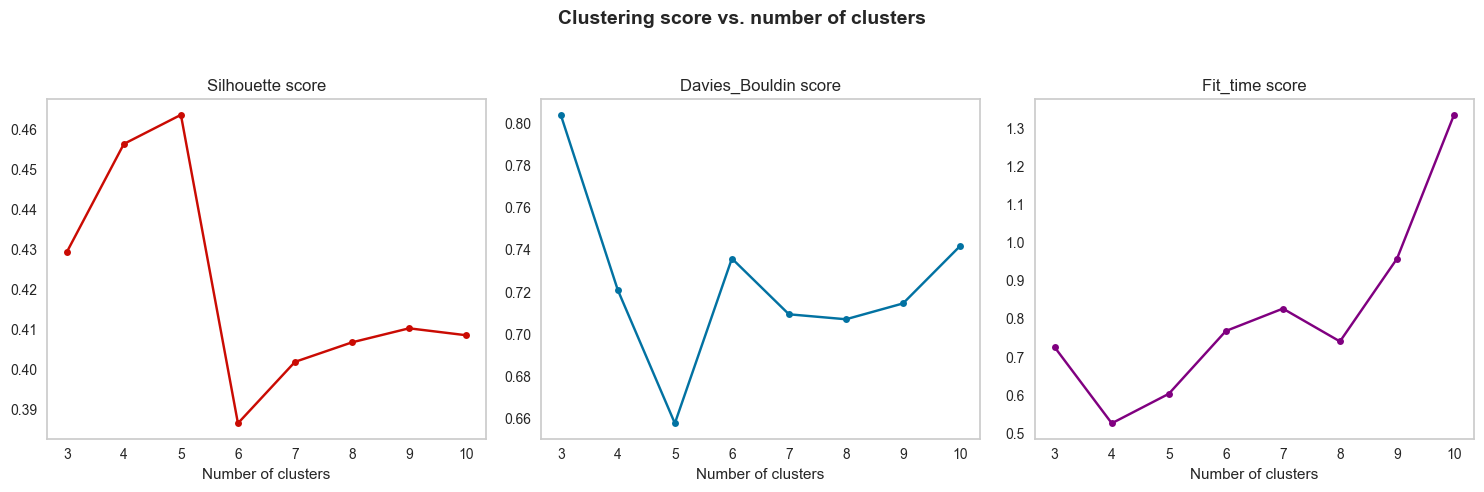

In [151]:
scores_rfm_review_deliv_delay_categ_time = compute_clust_scores_nclust_time(KMeans(), rfm_review_deliv_delay_categ, n_iter=1, num_clusters=range(3,11))
plot_scores_vs_n_clust_time(scores_rfm_review_deliv_delay_categ_time, figsize=(15,5))

De par ces résultats, **le nb de clusters le plus adapté est 5**.

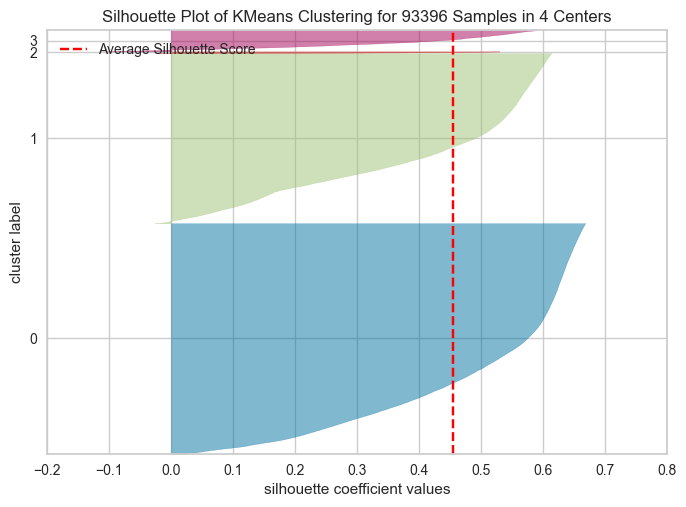

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 93396 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [152]:
# Instantiate a KMeans clustering model
model = KMeans(n_clusters=4, random_state=42)

# Instantiate a silhouette visualizer with 4 clusters
visualizer = SilhouetteVisualizer(estimator=model, colors='yellowbrick', n_clusters=4)

# Fit the visualizer to your data
visualizer.fit(rfm_review_deliv_delay_categ)

# Render the visualization
visualizer.show()

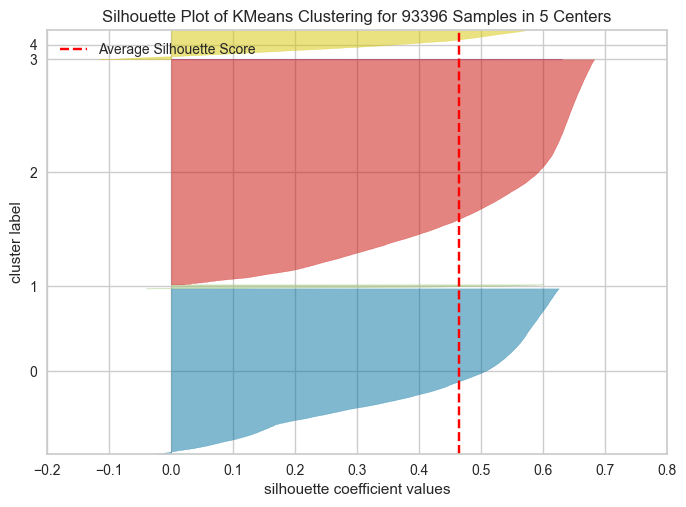

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 93396 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [153]:
# Instantiate a KMeans clustering model
model = KMeans(n_clusters=5, random_state=42)

# Instantiate a silhouette visualizer with 5 clusters
visualizer = SilhouetteVisualizer(estimator=model, colors='yellowbrick', n_clusters=5)

# Fit the visualizer to your data
visualizer.fit(rfm_review_deliv_delay_categ)

# Render the visualization
visualizer.show()

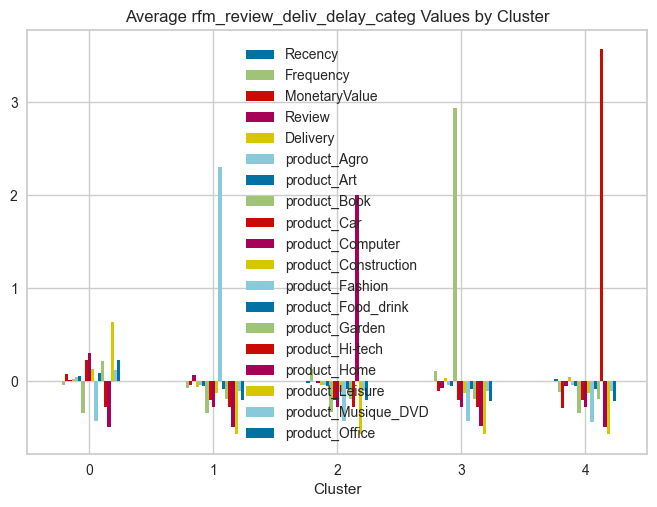

In [154]:
# Fit the KMeans model with the optimal number of clusters
kmeans = KMeans(n_clusters=5, random_state=42)
rfm_review_deliv_delay_categ_scaled = StandardScaler().fit_transform(rfm_review_deliv_delay_categ)
kmeans.fit(rfm_review_deliv_delay_categ_scaled)

# Assign each customer to a cluster
variables = rfm_review_deliv_delay_categ.columns
rfm_review_deliv_delay_categ_clustered = pd.DataFrame(rfm_review_deliv_delay_categ_scaled.copy(), columns=variables)
rfm_review_deliv_delay_categ_clustered['cluster_kmeans'] = kmeans.labels_

# Calculate the average rfm_review_deliv_delay_categ values for each cluster
rfm_review_deliv_delay_categ_clustered.groupby('cluster_kmeans').mean()

# Create a bar chart of the average rfm_review_deliv_delay_categ values for each cluster
rfm_review_deliv_delay_categ_clustered.groupby('cluster_kmeans').mean().plot(kind='bar')
plt.title('Average rfm_review_deliv_delay_categ Values by Cluster')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

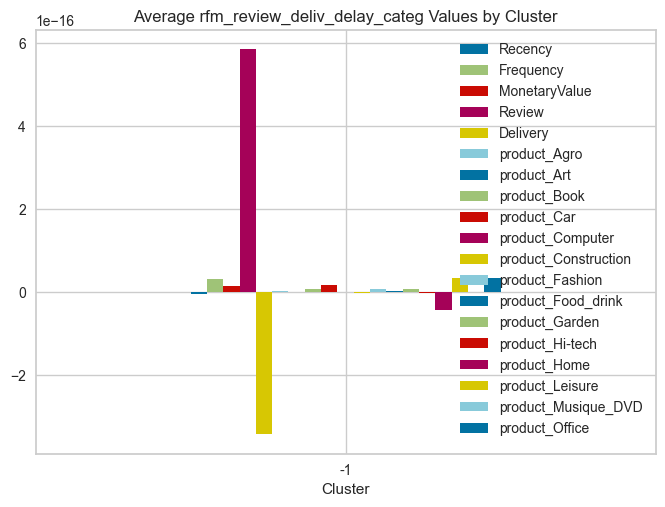

In [155]:
# DBSCAN
X = rfm_review_deliv_delay_categ_scaled.copy()

# Instancier la classe DBSCAN
dbscan = DBSCAN(eps=0.01, min_samples = (len(X)/5000))

# Appliquer l'algorithme DBSCAN sur les données
dbscan.fit(X)

# Identifier les clusters résultants
labels = dbscan.labels_

# Create new column with the labels
rfm_review_deliv_delay_categ_clustered["cluster_dbscan"] = labels

# Create a bar chart of the average rfm_review_deliv_delay_categ values for each cluster
rfm_review_deliv_delay_categ_clustered.drop(columns="cluster_kmeans").groupby('cluster_dbscan').mean().plot(kind='bar')
plt.title('Average rfm_review_deliv_delay_categ Values by Cluster')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

Le DBScan classifie très mal.

In [156]:
# Calculer l'indice de silhouette
silhouette = silhouette_score(X, labels)
print("Indice de silhouette :", silhouette)

# Calculer l'indice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(X, labels)
print("Indice de Davies-Bouldin :", davies_bouldin)

# Générer un regroupement aléatoire pour comparer les résultats
random_labels = np.random.randint(0, 3, size=len(X))
silhouette_random = silhouette_score(X, random_labels)
davies_bouldin_random = davies_bouldin_score(X, random_labels)
print("Indice de silhouette pour un regroupement aléatoire :", silhouette_random)
print("Indice de Davies-Bouldin pour un regroupement aléatoire :", davies_bouldin_random)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

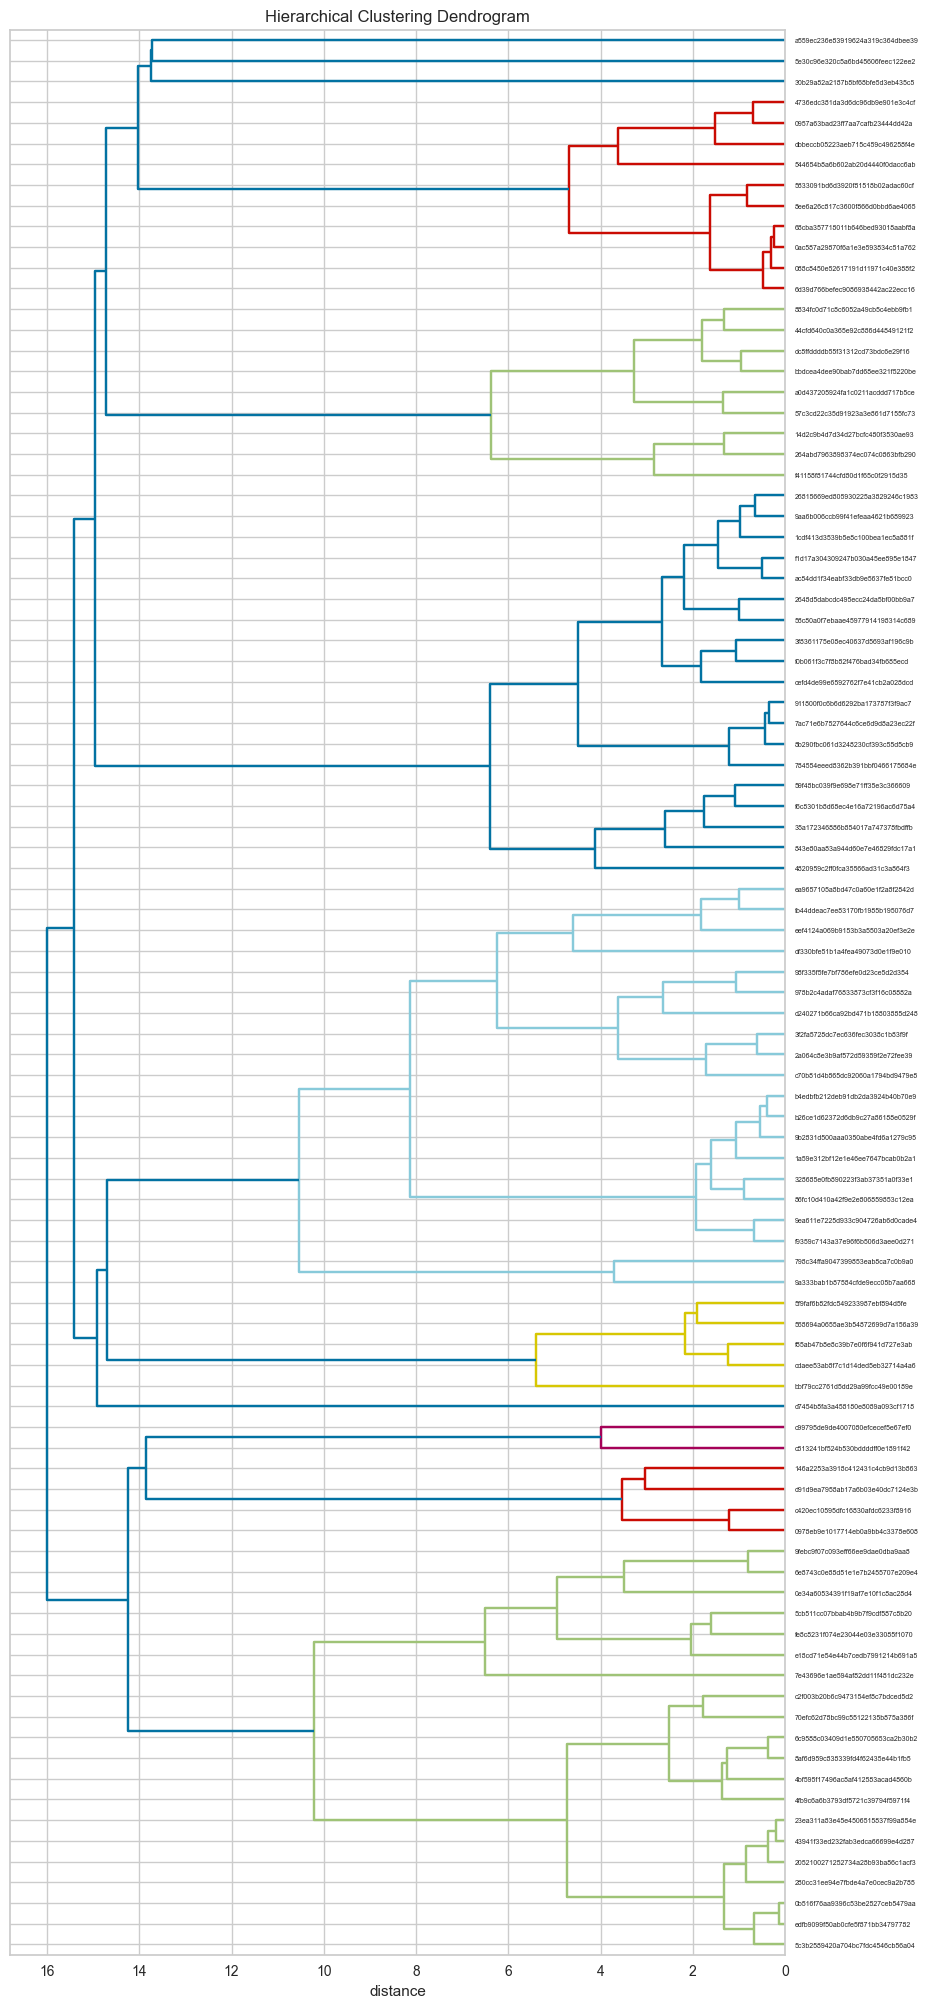

In [157]:
# Agglomerative clustering / Dendrogramme

# Préparation des données pour le clustering
dendrogramme = rfm_review_deliv_delay_categ.sample(n=round((len(rfm_review_deliv_delay_categ)/1000))) # Echantillon car sinon df trop important
X = dendrogramme.values
names = dendrogramme.index

# Centrage et Réduction
std_scale = StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z, names)

In [158]:
# Créer un dataframe pour chaque cluster
clusters = rfm_review_deliv_delay_categ_clustered.groupby('cluster_kmeans')

# Récupérer les noms des clusters
cluster_names = rfm_review_deliv_delay_categ_clustered['cluster_kmeans'].unique()

# Créer une figure Plotly avec 6 sous-figures polar
fig = make_subplots(rows=2, cols=3, subplot_titles=[f'Cluster {name}' for name in cluster_names], specs=[[{'type': 'polar'}]*3]*2, horizontal_spacing=0.001, vertical_spacing=0.2)

# Parcourir les clusters et ajouter un radar plot à chaque sous-figure
for i, cluster in enumerate(clusters):
    data11 = cluster[1][variables].mean().values.flatten().tolist()
    data11 += data11[:1]

    fig.add_trace(go.Scatterpolar(
        r=data11,
        theta=variables ,
        fill='toself',
        name=f'Cluster {cluster_names[i]}'
    ), row=(i // 3) + 1, col=(i % 3) + 1)

    # Ajouter les étiquettes des axes pour chaque sous-figure
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            ),
        ),
        showlegend=True,
        width=1800,
        height=900
    )

# Mettre à jour le titre de la figure
fig.update_layout(title_text='Radar plot des clusters')

# Afficher la figure
fig.show()

In [159]:
joblib.dump(rfm_review_deliv_delay_categ, "rfm_review_deliv_delay_categ_dataset")

['rfm_review_deliv_delay_categ_dataset']

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning:

All-NaN axis encountered

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning:

All-NaN axis encountered



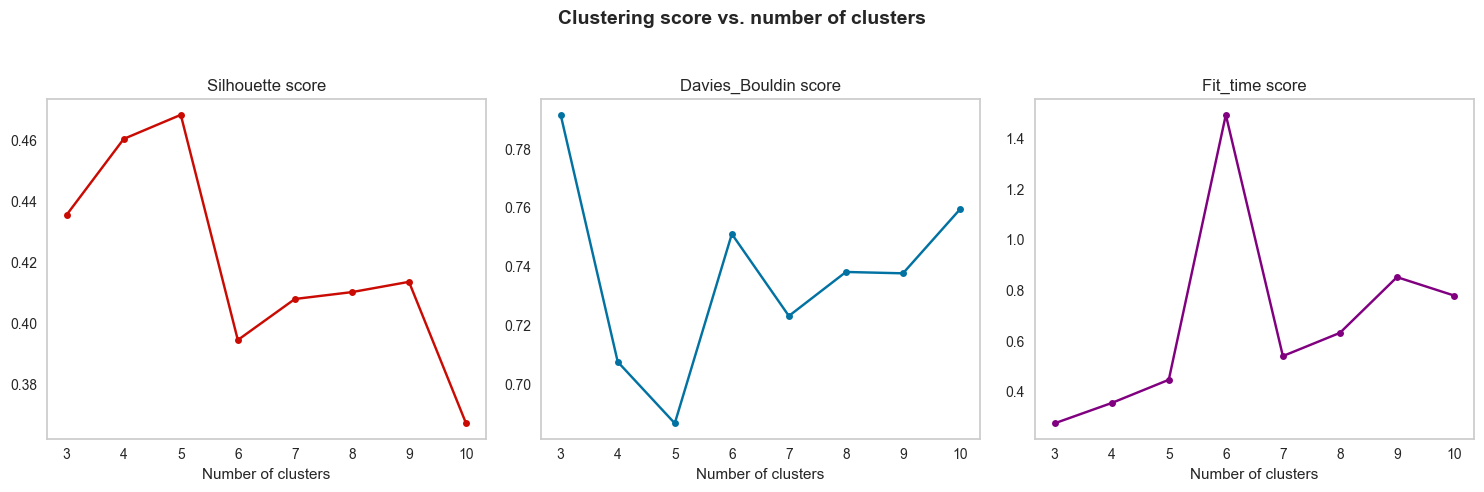

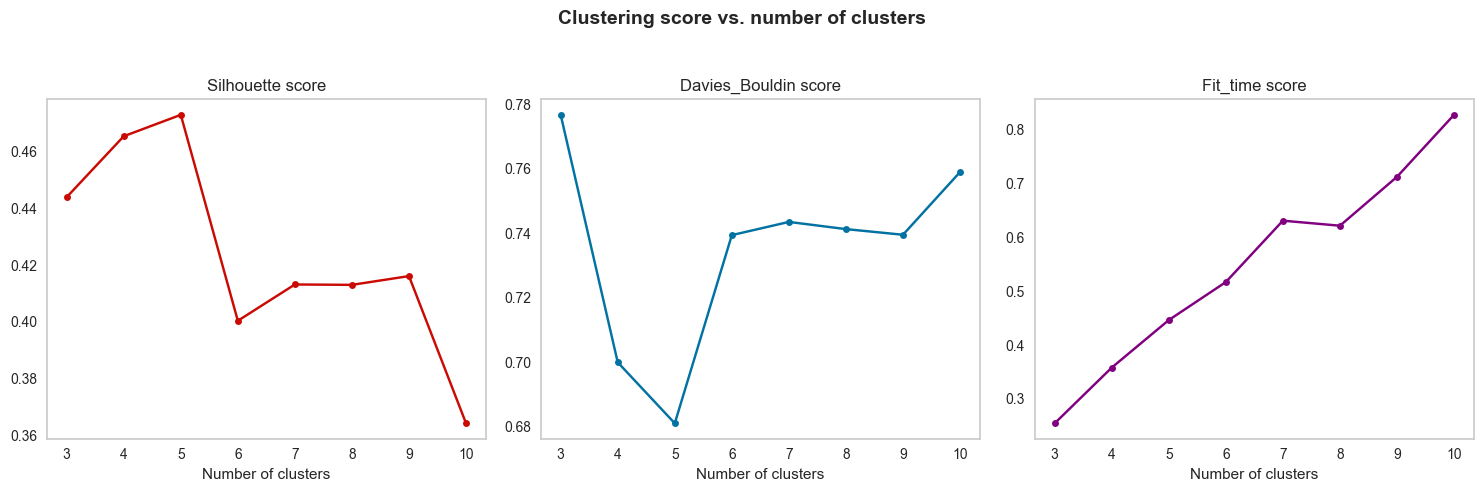

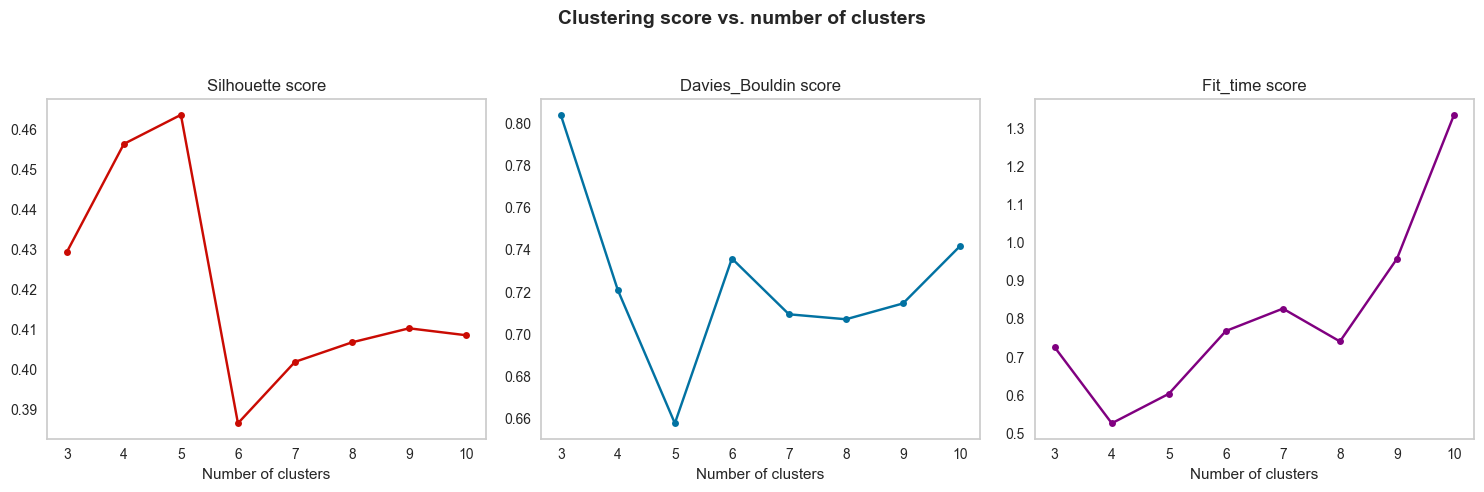

In [160]:
# Comparaison des datasets

plot_scores_vs_n_clust_time(scores_rfm_time, figsize=(15,5))
plot_scores_vs_n_clust_time(scores_rfm_review_deliv_delay_time, figsize=(15,5))
plot_scores_vs_n_clust_time(scores_rfm_review_deliv_delay_categ_time, figsize=(15,5))

##### Decision Tree

In [161]:
from sklearn.tree import DecisionTreeClassifier

In [162]:
datasets = [rfm_clustered, rfm_review_deliv_delay_clustered, rfm_review_deliv_delay_categ_clustered]

for dataset in datasets :
    X_tr = dataset.drop(columns=['cluster_kmeans', 'cluster_dbscan'], axis=1)
    y_tr = dataset['cluster_kmeans']

    scaler = MinMaxScaler()    
    X_tr_scaled = scaler.fit_transform(X_tr)
    tree = DecisionTreeClassifier(random_state=42)
    tree = tree.fit(X_tr_scaled, y_tr)

    feature_importances = pd.Series(tree.feature_importances_,
                                    index = X_tr.columns,
                                    name='Feature importance')\
                                    .sort_values(ascending=False)
    
    fig = px.bar(data_frame=feature_importances, y=feature_importances.values, x=list(feature_importances.index), title='Features importances')
    fig.show()


Les datasets fonctionnent, pas de variable qui écrase les autres hormis les variables RFM.

Tous les clusterings se font avec 5 clusters. On remarque que le deuxième dataset a un bien meilleur silhouette_score que le premier, et que le troisième n'améliore pas la performance et prend plus de temps à modéliser. On choisit donc le deuxième dataset pour la suite.

In [163]:
# Segmentation

rfm_review_deliv_delay_clustered

,Frequency,Review,Delivery,MonetaryValue,Recency,cluster_kmeans,cluster_dbscan
0,-0.816322,-0.289535,-0.065620,0.638856,-0.648071,1,-1
1,-0.796860,-0.289535,-0.561555,-0.867092,-1.042213,1,-1
2,1.947342,-0.289535,-0.337714,-2.373040,1.848164,4,-1
3,0.546047,-0.289535,-0.529878,-0.867092,1.191260,4,-1
4,0.331961,-0.289535,0.158220,0.638856,0.271594,2,-1
...,...,...,...,...,...,...,...
79888,1.363469,1.073084,6.368573,0.638856,2.110925,3,-1
79889,0.163286,-0.289535,-0.356077,-0.867092,2.505067,4,-1
79890,2.148453,-0.289535,-0.244336,0.638856,0.402975,2,-1
79891,-0.764422,-0.289535,-0.132192,0.638856,0.008833,1,-1


In [164]:
# Segmentation

rfm_review_deliv_delay_clustered.drop("cluster_dbscan", axis=1).groupby("cluster_kmeans").mean().reset_index()

,cluster_kmeans,Frequency,Review,Delivery,MonetaryValue,Recency
0,0,-0.007401,3.992908,0.738332,-0.090905,-0.063327
1,1,-0.798283,-0.157381,-0.140411,0.451182,-0.336832
2,2,0.995975,-0.146017,-0.114242,0.462942,0.072725
3,3,-0.018443,0.214690,5.167192,0.125766,0.131542
4,4,0.023094,-0.111645,-0.113695,-1.492099,0.509804


In [166]:
rfm_review_deliv_delay_clustered.cluster_kmeans.value_counts(normalize=True)

1    0.406018
2    0.320867
4    0.221859
0    0.032957
3    0.018299
Name: cluster_kmeans, dtype: float64

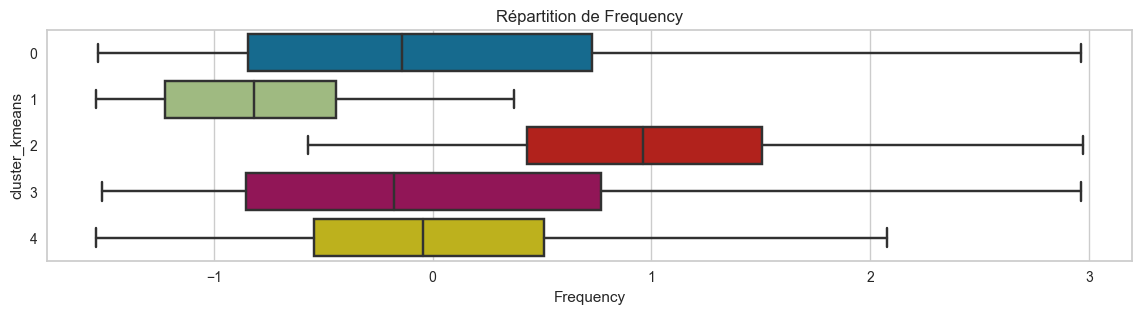

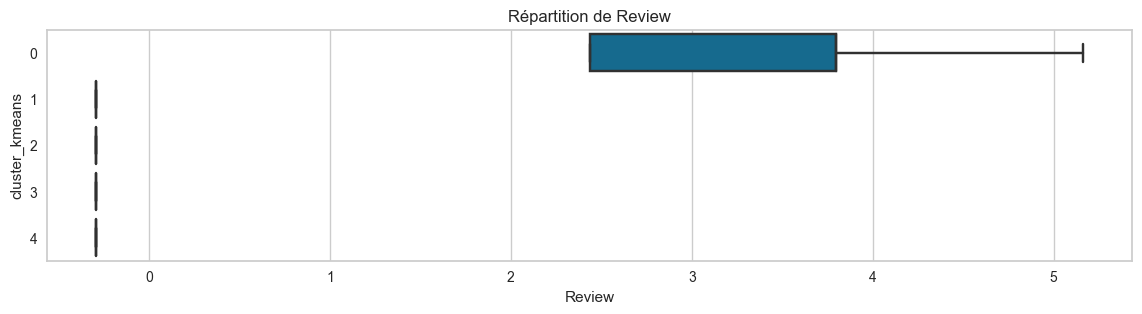

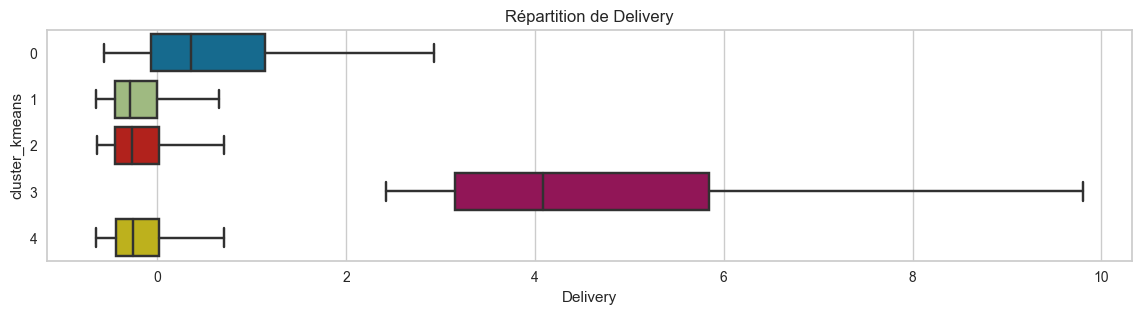

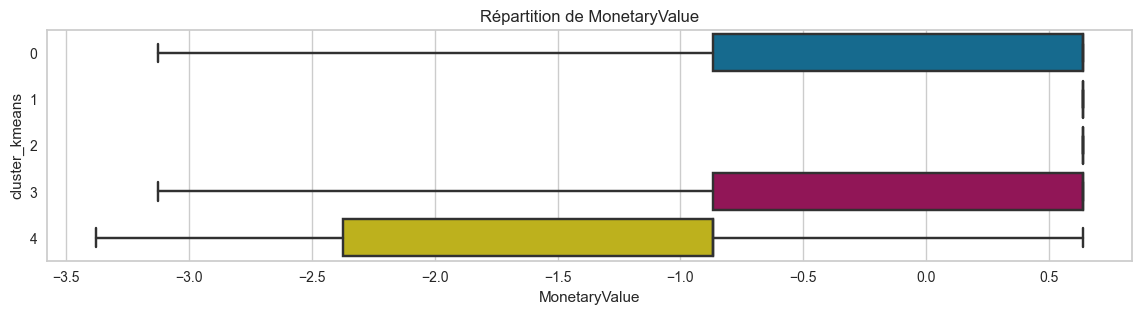

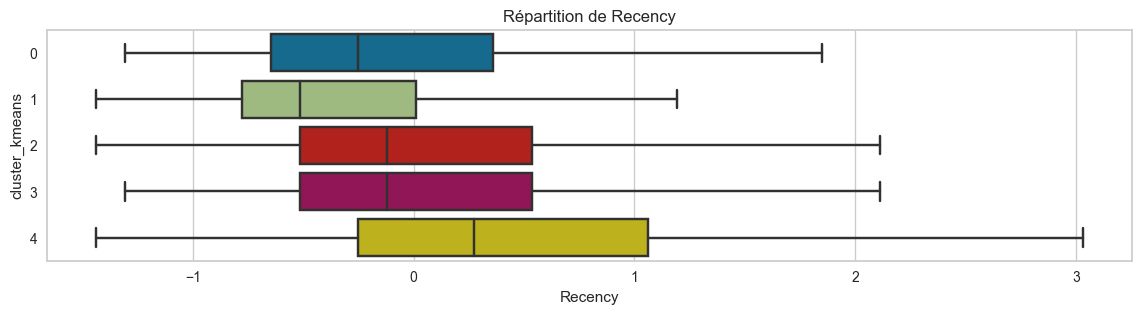

In [165]:
for column in rfm_review_deliv_delay_clustered.columns[:-2]:
    plt.figure(figsize=(14,3))
    sns.boxplot(data=rfm_review_deliv_delay_clustered, x=column, y="cluster_kmeans", orient = "h", showfliers=False)
    plt.title(f"Répartition de {column}")
    plt.show()

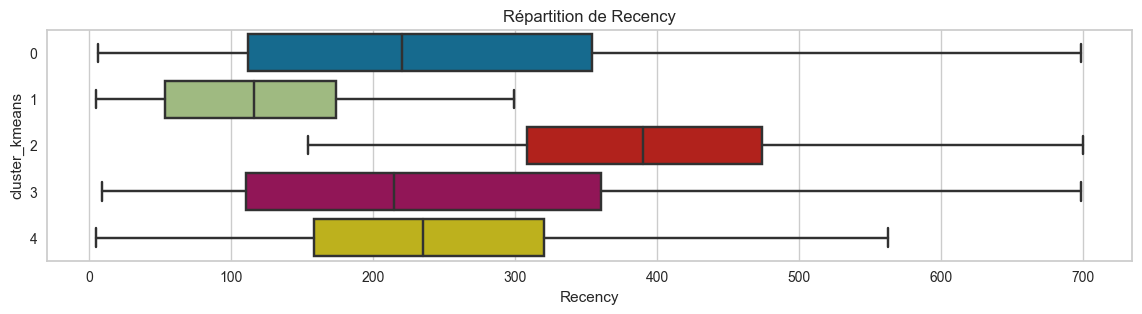

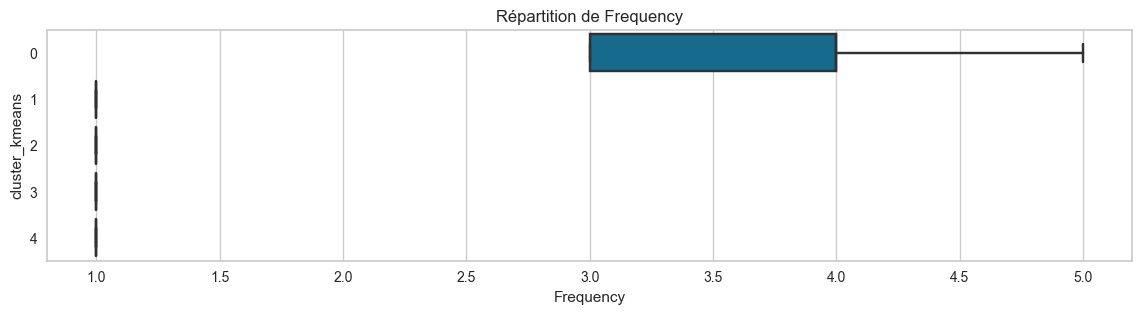

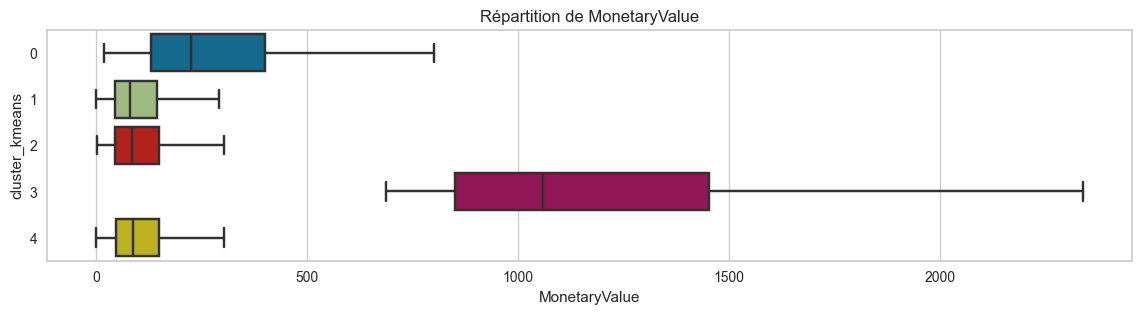

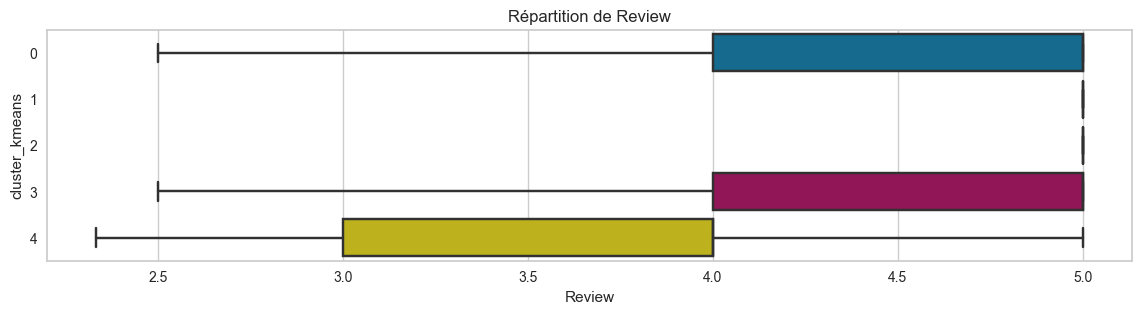

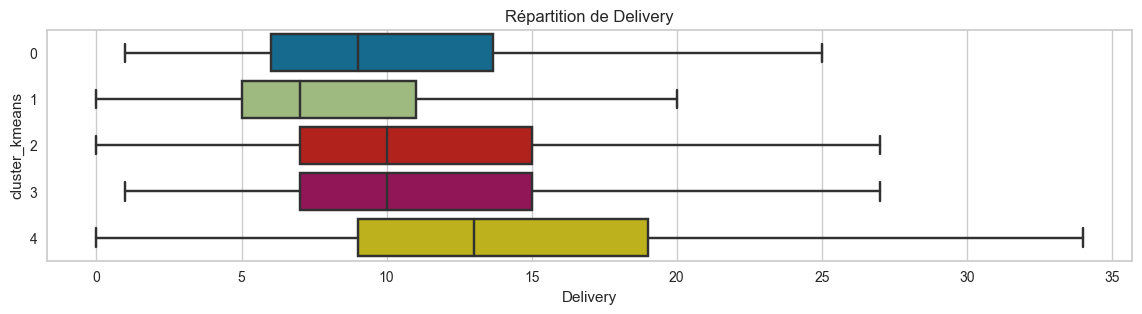

In [170]:
kmeans = KMeans(n_clusters=5, random_state=42)
rfm_review_deliv_delay_scaled = StandardScaler().fit_transform(rfm_review_deliv_delay)
kmeans.fit(rfm_review_deliv_delay_scaled)

rfm_review_deliv_delay['cluster_kmeans'] = kmeans.labels_

for column in rfm_review_deliv_delay.columns[:-1]:
    plt.figure(figsize=(14,3))
    sns.boxplot(data=rfm_review_deliv_delay, x=column, y="cluster_kmeans", orient = "h", showfliers=False)
    plt.title(f"Répartition de {column}")
    plt.show()

In [ ]:
# Segmentation

